# Test Part 1 - Data Preprocessing

In [1]:
from pathlib import Path
import re
from typing import List, Tuple, Dict, Optional
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import urllib.request
import zipfile
import shutil
import os


In [2]:
# ----------------------------
# 0) Config
# ----------------------------
DATA_URL = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jwyy9np4gv-3.zip" #download dataset if is required

DATA_DIR = Path("./Audio Files")  # <-- CHANGE THIS
OUTPUT_DIR = Path("./outputs_part1_clean")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Part 1 — Ingest + Exploratory Data Analysis (EDA)

This section focuses on robust dataset ingestion, parsing, and initial exploratory analysis.

**Steps performed:**
- **Dataset download & extraction**  
  - Download outer ZIP and recursively extract nested archives.  
  - Verify presence of `.wav` audio files.  

- **Location parsing**  
  - Normalize anatomical recording location (Plane–Side–Level).  
  - Handle irregular tokenization (3-letter glued codes, 4-token cases).  
  - Validate and audit parsing outcomes.  

- **Sound types & diagnosis normalization**  
  - Standardize sound codes/words (e.g., *I, E, W, C, N*).  
  - Map diagnoses to canonical labels (e.g., Asthma, COPD, Pneumonia).  
  - Split mixed header tokens into sound types vs. diagnoses.  

- **Filename parsing**  
  - Extract metadata: patient ID, filter (Bell/Diaphragm/Extended), location, age, gender.  
  - Build structured records combining parsed attributes.  

- **Dataset scanning**  
  - Traverse all `.wav` files and build wide/long DataFrames.  
  - Explode multi-label fields (diagnosis, sound type) for analysis.  

- **Frequency tables & simple plots**  
  - Compute counts by filter, location, gender, diagnosis, sound type.  
  - Generate bar charts and boxplots (age vs. diagnosis).  


In [3]:
# ============================
# Part 1 — Ingest + EDA (clean, robust, audited)
# ============================



    # ============================
    # 0) Download and extract dataset 
    # ============================
def download_and_extract(url: str = DATA_URL,
                         work_dir: Path = Path("./data_raw"),
                         extract_dirname: str = "jwyy9np4gv-3",
                         force_redownload: bool = False) -> Path:
    """
    Download the dataset ZIP and extract all nested zips (Audio Files, Stethoscope Files).
    - After execution you should have all .wav files available under work_dir/extract_dirname.
    - Returns the path to the extracted main folder.
    """
    work_dir = Path(work_dir)
    work_dir.mkdir(parents=True, exist_ok=True)
    zip_path = work_dir / "lung_sounds.zip"
    extract_dir = work_dir / extract_dirname

    # If already extracted with WAVs, skip
    if extract_dir.exists() and any(extract_dir.rglob("*.wav")) and not force_redownload:
        print(f"[OK] Dataset already available at: {extract_dir}")
        return extract_dir

    # Clean up if forced
    if force_redownload:
        if zip_path.exists():
            zip_path.unlink()
        if extract_dir.exists():
            shutil.rmtree(extract_dir, ignore_errors=True)

    # Download the outer ZIP
    if not zip_path.exists():
        print(f"[...] Downloading dataset from:\n{url}")
        urllib.request.urlretrieve(url, zip_path)
        print(f"[OK] ZIP saved at: {zip_path}")

    # Extract outer ZIP
    print(f"[...] Extracting outer ZIP to: {extract_dir}")
    extract_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)

    # Now extract inner zips if they exist
    for inner_zip in ["Audio Files.zip", "Stethoscope Files.zip"]:
        inner_path = extract_dir / inner_zip
        if inner_path.exists():
            inner_target = extract_dir / inner_zip.replace(".zip", "")
            print(f"[...] Extracting nested zip: {inner_zip}")
            inner_target.mkdir(parents=True, exist_ok=True)
            with zipfile.ZipFile(inner_path, "r") as zf:
                zf.extractall(inner_target)

    # Verify WAV files
    wavs = list(extract_dir.rglob("*.wav"))
    print(f"[OK] WAV files found: {len(wavs)}")
    return extract_dir




# ----------------------------
# 1) Location parsing (official P/A, L/R, U/M/L) with 4-token handling
# ----------------------------
PLANE_FULL = {"P": "Posterior", "A": "Anterior"}
SIDE_FULL  = {"L": "Left", "R": "Right"}
LEVEL_FULL = {"U": "Upper", "M": "Middle", "L": "Lower"}

def _loc_tokenize(raw: str):
    """Tokenize location: uppercase, remove commas/tabs, split on whitespace; handle glued 3-char like 'PRU'."""
    s = re.sub(r"[,+\t]+", " ", str(raw).strip().upper())
    toks = [t for t in re.split(r"\s+", s) if t]
    if len(toks) == 1 and len(toks[0]) == 3:  # e.g., 'PRU'
        toks = list(toks[0])
    return toks

def _explode_letters(tokens: List[str]):
    """If any token has multiple letters and no spaces, split into single letters (e.g., 'LR' -> ['L','R'])."""
    out = []
    for t in tokens:
        t = t.strip().upper()
        if not t:
            continue
        if len(t) > 1 and " " not in t:
            out.extend(list(t))
        else:
            out.append(t)
    return out

def parse_location_official(raw: Optional[str]):
    out = {
        "location_raw": raw,
        "location_norm": None,
        "location_valid": False,
        "location_issue": None,
        "location_tokens_count": None,
        "location_had_4_tokens": False,
        "plane_tok": None,
        "side_tok": None,
        "level_tok": None,
    }
    if raw is None or str(raw).strip() == "":
        out["location_issue"] = "missing location"
        return out

    # --- tokenize & plane ---
    s = re.sub(r"[,+\t]+", " ", str(raw).strip().upper())
    toks = [t for t in re.split(r"\s+", s) if t]
    if len(toks) == 1 and len(toks[0]) == 3:  # e.g. 'PRL'
        toks = list(toks[0])
    out["location_tokens_count"] = len(toks)

    plane, rest = toks[0], toks[1:]
    if plane not in PLANE_FULL:
        if len(plane) >= 2 and plane[0] in PLANE_FULL:
            chars = list(plane) + sum((list(t) for t in rest), [])
            plane, rest = chars[0], chars[1:]
        else:
            out["location_issue"] = f"invalid plane '{plane}'";  return out

    # explode letters (e.g. 'LR' -> ['L','R'])
    exploded = []
    for t in rest:
        t = t.strip().upper()
        exploded.extend(list(t) if len(t) > 1 and " " not in t else [t])
    rest = exploded
    if not rest:
        out.update({"plane_tok": plane, "location_issue": "missing side and level"})
        return out

    if len(rest) >= 4:
        out["location_had_4_tokens"] = True

    # --- FIX: pick LEVEL first (rightmost U/M/L), then SIDE (rightmost L/R excluding level index) ---
    level_idx = None
    for i in range(len(rest) - 1, -1, -1):
        if rest[i] in LEVEL_FULL:
            level_idx = i
            break

    side_idx = None
    for i in range(len(rest) - 1, -1, -1):
        if i == level_idx:
            continue
        if rest[i] in SIDE_FULL:
            side_idx = i
            break

    # handle issues
    if level_idx is None and side_idx is None:
        out.update({"plane_tok": plane, "location_issue": "no side and no level found"})
        return out
    if level_idx is None:
        out.update({"plane_tok": plane, "side_tok": rest[side_idx], "location_issue": "missing level"})
        return out
    if side_idx is None:
        out.update({"plane_tok": plane, "level_tok": rest[level_idx], "location_issue": "missing side"})
        return out

    plane_tok = plane
    level_tok = rest[level_idx]   # chosen first
    side_tok  = rest[side_idx]    # chosen excluding level index

    # validate & build label
    if plane_tok not in PLANE_FULL:
        out["location_issue"] = f"invalid plane '{plane_tok}'"; return out
    if side_tok not in SIDE_FULL:
        out["location_issue"] = f"invalid side '{side_tok}'";  return out
    if level_tok not in LEVEL_FULL:
        out["location_issue"] = f"invalid level '{level_tok}'"; return out

    out.update({
        "plane_tok": plane_tok,
        "side_tok": side_tok,
        "level_tok": level_tok,
        "location_norm": f"{PLANE_FULL[plane_tok]} {SIDE_FULL[side_tok]} {LEVEL_FULL[level_tok]}",
        "location_valid": True,
        "location_issue": None,
    })
    return out


# ----------------------------
# 2) Sound types + diagnosis normalization
# ----------------------------
SOUND_CODE_MAP = {
    "I": "Inspiratory",
    "E": "Expiratory",
    "W": "Wheezes",
    "C": "Crackles",
    "N": "Normal",
    "B": "Bronchial",
}
SOUND_WORD_MAP = {
    "inspiratory": "Inspiratory",
    "expiratory": "Expiratory",
    "wheeze": "Wheezes",
    "wheezes": "Wheezes",
    "crackle": "Crackles",
    "crackles": "Crackles",
    "crep": "Crackles",
    "crepitations": "Crackles",
    "normal": "Normal",
    "bronchial": "Bronchial",
}
def _sound_from_word(word: str):
    """Return standardized sound types for codes ('EW', 'I C') or words ('Crep', 'Bronchial')."""
    if not word:
        return []
    w_clean = re.sub(r"[^A-Za-z]", "", word)
    if not w_clean:
        return []
    up = w_clean.upper()
    if up in SOUND_CODE_MAP:  # single letter
        return [SOUND_CODE_MAP[up]]
    if re.fullmatch(r"[IEWCBN]+", up):  # glued letters like 'IEW'
        return [SOUND_CODE_MAP[ch] for ch in up]
    lw = w_clean.lower()
    if lw in SOUND_WORD_MAP:
        return [SOUND_WORD_MAP[lw]]
    return []

# Diagnosis canonical map (extend as needed)
DIAG_CANONICAL = {
    "n": "Normal",
    "N": "Normal",
    "normal": "Normal",
    "asthma": "Asthma",
    "copd": "COPD",
    "pneumonia": "Pneumonia",
    "heart failure": "Heart Failure",
    "lung fibrosis": "Lung Fibrosis",
    "bron": "BRON",                      # keep BRON label, or map to 'Bronchiectasis/Bronchitis'
    "bronchitis": "BRON",
    "bronchiectasis": "BRON",
    "pleural effusion": "Pleural Effusion",
}

def normalize_diagnosis_label(text: str):
    """Normalize diagnosis to a canonical label (case-insensitive)."""
    t = re.sub(r"\s+", " ", str(text).strip())
    key = t.lower()
    if key in DIAG_CANONICAL:
        return DIAG_CANONICAL[key]
    # Try simple heuristics
    if key.replace(".", "") == "copd":
        return "COPD"
    return t.title()  # default: title-case (e.g., 'Bronchial Asthma' -> 'Bronchial Asthma')

def split_diag_and_sound(head_tokens: List[str]):
    """
    HEAD may mix diagnoses and sound types. Split into:
      - diagnoses (canonicalized)
      - sound_types (standard labels)
    Accept '+', 'and', '&' as connectors; preserve order and de-duplicate.
    """
    diagnoses, sounds = [], []

    def dedup(seq):
        """
        Remove duplicates from a list while preserving the original order.
        Example: ["COPD","Asthma","COPD"] -> ["COPD","Asthma"]
        """
        seen, out = set(), []
        for x in seq:
            if x not in seen:
                seen.add(x); out.append(x)
        return out

    for token in head_tokens:
        if not token or not token.strip():
            continue
        # Normalize connectors to '+', and split underscores as well
        # Examples: "N_N" -> "N+N", "Asthma and COPD" -> "Asthma+COPD"
        norm = token.strip()
        norm = norm.replace("_", "+")
        norm = re.sub(r"\s+(?i:and)\s+|&", "+", norm)
        parts = [p.strip() for p in norm.split("+") if p.strip()]

        for part in parts:
            # Split remaining by whitespace into words/tokens
            words = [w for w in re.split(r"\s+", part) if w]
            local_sounds, diag_words = [], []
            for w in words:
                s = _sound_from_word(w)  # returns ['Normal'] for 'N'/'normal', etc.
                if s:
                    local_sounds.extend(s)
                else:
                    diag_words.append(w)

            if diag_words:
                # Join words back and normalize the diagnosis label
                diagnoses.append(normalize_diagnosis_label(" ".join(diag_words)))
            sounds.extend(local_sounds)

    diagnoses = dedup(diagnoses)
    sounds = dedup(sounds)

    # Special rule: if header is only 'N' (or variations) -> set diagnosis='Normal'
    if not diagnoses and any(st == "Normal" for st in sounds):
        diagnoses = ["Normal"]

    return diagnoses, sounds

# ----------------------------
# 3) Filename parser
# ----------------------------
FILTER_MAP = {"BP": "Bell", "DP": "Diaphragm", "EP": "Extended"}

def parse_filename(fname: str):
    """
    Expected: <FILTER><ID>_<HEAD>,<LOCATION>,<AGE>,<GENDER>.wav
    - HEAD can mix diagnoses and sound-type hints (codes or words).
    - LOCATION normalized via official Plane–Side–Level with 4-token handling.
    """
    name = Path(fname).name
    if not name.lower().endswith(".wav"):
        return None
    stem = name[:-4]
    if "_" not in stem:
        return None

    left, right = stem.split("_", 1)
    m = re.match(r"^(BP|DP|EP)(\d+)$", left, re.IGNORECASE)
    if not m:
        return None
    filter_code = m.group(1).upper()
    patient_id = m.group(2)

    parts = [p.strip() for p in right.split(",")]
    gender = parts[-1] if len(parts) >= 1 else None
    age = None
    if len(parts) >= 2:
        try:
            age = int(re.sub(r"[^0-9]", "", parts[-2]))
        except Exception:
            age = None
    location_raw = parts[-3] if len(parts) >= 3 else None
    head_tokens  = parts[:-3] if len(parts) >= 4 else (parts[:1] if len(parts) >= 1 else [])

    # Normalize gender (M/F)
    if isinstance(gender, str):
        g = gender.strip().upper()
        gender = g if g in {"M","F"} else (g[:1] if g else None)

    # Split HEAD into diagnoses and sound types
    diagnoses, sound_types = split_diag_and_sound(head_tokens)

    # Parse location with audits
    loc = parse_location_official(location_raw)

    return {
        "filename": name,
        "filter_code": filter_code,
        "filter": FILTER_MAP.get(filter_code, filter_code),
        "patient_id": patient_id,
        "diagnoses": diagnoses,            # normalized diagnoses
        "sound_types": sound_types,        # normalized sound types
        "location_raw": loc["location_raw"],
        "location_norm": loc["location_norm"],
        "location_valid": loc["location_valid"],
        "location_issue": loc["location_issue"],
        "location_tokens_count": loc["location_tokens_count"],
        "location_had_4_tokens": loc["location_had_4_tokens"],
        "plane_tok": loc["plane_tok"],
        "side_tok":  loc["side_tok"],
        "level_tok": loc["level_tok"],
        "age": age,
        "gender": gender,
    }

# ----------------------------
# 4) Scan + DataFrames
# ----------------------------
def scan_dataset(data_dir: Path):
    """Return df_wide, df_long_diag (explode), df_long_sound (explode)."""
    wavs = list(data_dir.rglob("*.wav"))
    rows = []
    for p in wavs:
        info = parse_filename(p.name)
        if info:
            info["filepath"] = str(p)
            rows.append(info)
    df_wide = pd.DataFrame(rows)

    if not df_wide.empty:
        df_long_diag  = df_wide.explode("diagnoses",   ignore_index=True).rename(columns={"diagnoses":"diagnosis"})
        df_long_sound = df_wide.explode("sound_types", ignore_index=True).rename(columns={"sound_types":"sound_type"})
        df_long_diag["diagnosis"]   = df_long_diag["diagnosis"].fillna("").astype(str).str.strip()
        df_long_sound["sound_type"] = df_long_sound["sound_type"].fillna("").astype(str).str.strip()
        df_long_diag  = df_long_diag[df_long_diag["diagnosis"]   != ""]
        df_long_sound = df_long_sound[df_long_sound["sound_type"] != ""]
    else:
        df_long_diag  = pd.DataFrame(columns=["filename","diagnosis"])
        df_long_sound = pd.DataFrame(columns=["filename","sound_type"])

    return df_wide, df_long_diag, df_long_sound

# ----------------------------
# 5) Frequencies + simple plots
# ----------------------------
def frequency_tables(df_wide: pd.DataFrame, df_long_diag: pd.DataFrame, df_long_sound: pd.DataFrame):
    out = {}
    if not df_wide.empty:
        out["count_by_filter_code"] = df_wide["filter_code"].value_counts().rename_axis("filter_code").to_frame("count")
        out["count_by_filter"] = df_wide["filter"].value_counts().rename_axis("filter").to_frame("count")
        out["count_by_location_norm"] = df_wide["location_norm"].value_counts(dropna=False).rename_axis("location_norm").to_frame("count")
        out["count_by_gender"] = df_wide["gender"].value_counts(dropna=False).rename_axis("gender").to_frame("count")
        out["count_bad_location"] = df_wide.loc[~df_wide["location_valid"] | df_wide["location_norm"].isna(), "location_issue"]\
                                          .value_counts().rename_axis("issue").to_frame("count")
    else:
        out["count_by_filter_code"] = pd.DataFrame()
        out["count_by_filter"] = pd.DataFrame()
        out["count_by_location_norm"] = pd.DataFrame()
        out["count_by_gender"] = pd.DataFrame()
        out["count_bad_location"] = pd.DataFrame()

    if not df_long_diag.empty:
        diag_abs = df_long_diag["diagnosis"].value_counts().rename("count").to_frame()
        diag_rel = (diag_abs["count"]/diag_abs["count"].sum()).rename("relative").to_frame()
        out["diagnosis_abs"] = diag_abs
        out["diagnosis_rel"] = diag_rel
    else:
        out["diagnosis_abs"] = pd.DataFrame(); out["diagnosis_rel"] = pd.DataFrame()

    if not df_long_sound.empty:
        snd_abs = df_long_sound["sound_type"].value_counts().rename("count").to_frame()
        snd_rel = (snd_abs["count"]/snd_abs["count"].sum()).rename("relative").to_frame()
        out["sound_abs"] = snd_abs
        out["sound_rel"] = snd_rel
    else:
        out["sound_abs"] = pd.DataFrame(); out["sound_rel"] = pd.DataFrame()

    return out

def plot_bar(series: pd.Series, title: str, xlabel: str, ylabel: str, rotation: int = 0, fname: Optional[Path] = None):
    plt.figure(figsize=(8,5))
    series.plot(kind="bar")
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xticks(rotation=rotation); plt.tight_layout()
    if fname: plt.savefig(fname, dpi=150)
    plt.show(); plt.close()

def plot_age_vs_diagnosis_box(df_long_diag: pd.DataFrame, fname: Optional[Path] = None):
    sub = df_long_diag.dropna(subset=["age","diagnosis"]).copy()
    if sub.empty:
        print("[WARN] No rows with age+diagnosis for boxplot."); return
    diagnoses = list(sub["diagnosis"].unique())
    data = [sub.loc[sub["diagnosis"]==d, "age"].values for d in diagnoses]
    plt.figure(figsize=(10,5))
    plt.boxplot(data, labels=diagnoses, showfliers=False)
    plt.title("Age distribution by diagnosis (explode)")
    plt.xlabel("Diagnosis"); plt.ylabel("Age (years)")
    plt.tight_layout()
    if fname: plt.savefig(fname, dpi=150)
    plt.show(); plt.close()


In [4]:
#Download the dataset or check if it exists
root_dir = download_and_extract(url=DATA_URL, work_dir=DATA_DIR)

[...] Downloading dataset from:
https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/jwyy9np4gv-3.zip
[OK] ZIP saved at: Audio Files/lung_sounds.zip
[...] Extracting outer ZIP to: Audio Files/jwyy9np4gv-3
[...] Extracting nested zip: Audio Files.zip
[...] Extracting nested zip: Stethoscope Files.zip
[OK] WAV files found: 336


In [5]:
WAV_PATH = DATA_DIR / "jwyy9np4gv-3" / "Audio Files" # path to wav files
df_wide, df_long_diag, df_long_sound = scan_dataset(WAV_PATH)

# Save annotations
df_wide.to_csv(OUTPUT_DIR / "annotations_wide.csv", index=False)
df_long_diag.to_csv(OUTPUT_DIR / "annotations_long.csv", index=False)

# Quick audit
print("Parsed files:", len(df_wide))
print("Unique raw locations:", df_wide["location_raw"].nunique())
print("Rows with invalid/incomplete location:", (~df_wide["location_valid"] | df_wide["location_norm"].isna()).sum())
print("Rows with 4+ tokens in location:", df_wide["location_had_4_tokens"].sum())

# Inspect problematic locations
bad = df_wide.loc[~df_wide["location_valid"] | df_wide["location_norm"].isna(),
                  ["filename","location_raw","location_issue","location_tokens_count"]]
display(bad.head(20))



Parsed files: 336
Unique raw locations: 14
Rows with invalid/incomplete location: 3
Rows with 4+ tokens in location: 0


,filename,location_raw,location_issue,location_tokens_count
169,"EP26_Lung Fibrosis,Crep,P,90,F.wav",P,missing side and level,1
178,"DP26_Lung Fibrosis,Crep,P,90,F.wav",P,missing side and level,1
190,"BP26_Lung Fibrosis,Crep,P,90,F.wav",P,missing side and level,1


# Patient-Level Aggregation & Paper-Style Tables

This block aggregates per **patient** and generates tables/plots that mirror the paper’s summaries.


- **Patient-level aggregation**
  - Group `df_wide` by `patient_id`.
  - Merge and de-duplicate **sound types** and **diagnoses** per patient.
  - Pick the first valid **location** per patient; title-case it.

- **Table 1 — Chest zones (Location)**

- **Table 2 — Sound types (patient profile)**

- **Table 3 — Health condition (per diagnosis)**

- **Interactive visualizations**
  - **Boxplot (Plotly):** age distribution per diagnosis (shows points + box).
  - **Bar chart (Plotly):** diagnosis frequencies (unique patients).
  - **Co-occurrence heatmap (Seaborn):** pairwise counts of diagnoses across patients.





Table 1 — Chest zones (unique patients)
                        No. of Subjects
Location                               
Anterior Left Upper                   2
Anterior Right Lower                  4
Anterior Right Middle                 4
Anterior Right Upper                  6
Posterior Left Lower                 16
Posterior Left Middle                12
Posterior Left Upper                 11
Posterior Right Lower                26
Posterior Right Middle               16
Posterior Right Upper                14

Table 2 — Sound types (unique patients)
                      No. of Subjects
Sound Type                           
Normal                           35.0
Crepitations                     31.0
Wheezes                          41.0
Bronchial                         1.0
Wheezes & Crackles                2.0
Bronchial & Crackles              2.0

Table 3 — Health condition (unique patients)
                  No. of Subjects Age Range              Gender
Health Condition        

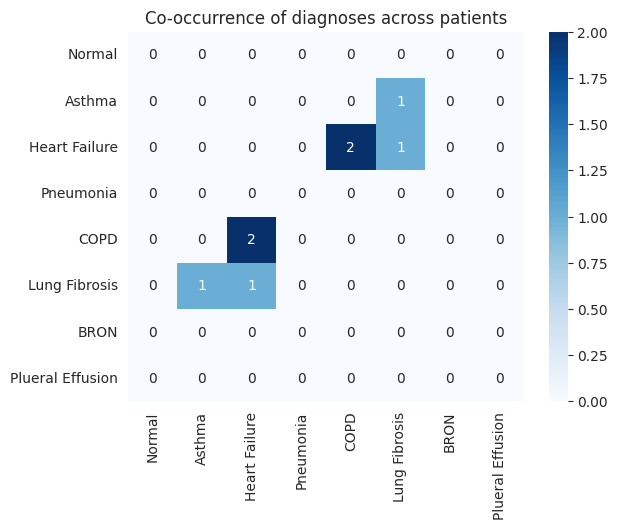

In [6]:
from pathlib import Path
import pandas as pd

SAVE_DIR = Path("./outputs_tables_like_paper")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

# ========= Helpers =========
def _dedup(seq):
    seen, out = set(), []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out

def _sound_profile_label(sound_list):
    """
    Map a patient's sound_types (unique) to the paper-like categories:
      - 'Normal'
      - 'Crepitations'  (we mapped Crep/Crackles → 'Crackles'; if usas 'Crackles' cámbialo aquí)
      - 'Wheezes'
      - 'Bronchial'
      - 'Crackles'
      - 'Wheezes & Crackles'
      - 'Bronchial & Crackles'
    Ajusta si tu normalización usa 'Crackles' en lugar de 'Crepitations'.
    """
    if not isinstance(sound_list, (list, tuple)) or len(sound_list) == 0:
        return None
    s = sorted(set(sound_list))
    # Nombres estándar esperados
    hasN  = "Normal"     in s
    hasW  = "Wheezes"    in s
    hasC  = "Crackles"   in s or "Crepitations" in s  # por si tu mapeo quedó como 'Crepitations'
    hasB  = "Bronchial"  in s

    # Normal si aparece y no hay otros tipos patológicos
    if hasN and not (hasW or hasC or hasB):
        return "Normal"

    # Combinaciones específicas que muestra el paper
    if hasW and hasC and not hasB:
        return "Wheezes & Crackles"
    if hasB and hasC and not hasW:
        return "Bronchial & Crackles"

    # Simples
    if hasW and not (hasC or hasB):
        return "Wheezes"
    if hasC and not (hasW or hasB):
        # Papel usa "Crepitations"; si prefieres "Crackles", cambia la cadena
        return "Crepitations"
    if hasB and not (hasW or hasC):
        return "Bronchial"

    # Si hay más de dos mezclas, conserva una etiqueta unida ordenada (para no perder casos)
    return " & ".join(s)

def _to_title(loc):
    """Ensure title-case for locations like 'Posterior right upper' -> 'Posterior Right Upper'."""
    return None if pd.isna(loc) else str(loc).title()

# ========= Base: colapsar por paciente =========
# Nota: si tienes múltiples filas por paciente con distintas ubicaciones/sonidos/diagnósticos,
# tomamos la PRIMERA por simplicidad para 'location'; para 'sound_types' y 'diagnoses'
# unimos y deduplicamos.
agg_rows = []
for pid, g in df_wide.groupby("patient_id", sort=False):
    row = g.iloc[0].copy()
    # sound_types y diagnoses unidas/deduplicadas a nivel paciente
    all_sounds = []
    all_diags  = []
    for _, r in g.iterrows():
        if isinstance(r.get("sound_types"), list):
            all_sounds.extend(r["sound_types"])
        if isinstance(r.get("diagnoses"), list):
            all_diags.extend(r["diagnoses"])
    row["sound_types_patient"] = _dedup([s for s in all_sounds if isinstance(s, str) and s.strip()])
    row["diagnoses_patient"]   = _dedup([d for d in all_diags  if isinstance(d, str) and d.strip()])
    # location: si hay varias distintas, prioriza la primera válida que aparezca
    loc = g["location_norm"].dropna()
    row["location_patient"] = loc.iloc[0] if not loc.empty else None
    agg_rows.append(row)

df_pat = pd.DataFrame(agg_rows)

# Normaliza formato de location a Title-Case (como el paper)
df_pat["location_patient"] = df_pat["location_patient"].map(_to_title)

# ========= Tabla 1: Chest zones (Location) =========
tbl_locations = (
    df_pat["location_patient"]
    .dropna()
    .value_counts()
    .rename_axis("Location")
    .to_frame("No. of Subjects")
    .sort_index()
)
print("\nTable 1 — Chest zones (unique patients)")
print(tbl_locations)
tbl_locations.to_csv(SAVE_DIR / "table1_locations.csv")

# ========= Tabla 2: Sound types (perfil por paciente) =========
df_pat["sound_profile"] = df_pat["sound_types_patient"].map(_sound_profile_label)
tbl_sound = (
    df_pat["sound_profile"]
    .dropna()
    .value_counts()
    .rename_axis("Sound Type")
    .to_frame("No. of Subjects")
)
# Reordenar para parecerse al paper
order_sound = [
    "Normal",
    "Crepitations",      # o "Crackles" si así lo decidiste
    "Wheezes",
    "Crackles",          # si tu mapping dejó "Crackles", lo verás aquí
    "Bronchial",
    "Wheezes & Crackles",
    "Bronchial & Crackles",
]
tbl_sound = tbl_sound.reindex(order_sound + [i for i in tbl_sound.index if i not in order_sound]).dropna(how="all")
print("\nTable 2 — Sound types (unique patients)")
print(tbl_sound)
tbl_sound.to_csv(SAVE_DIR / "table2_sound_types.csv")

# ========= Tabla 3: Health condition (conteo, rango de edad, género) =========
# Explode diagnósticos a nivel paciente, drop duplicates (un paciente cuenta una vez por condición)
tmp = df_pat.explode("diagnoses_patient", ignore_index=True)
tmp = tmp.rename(columns={"diagnoses_patient": "diagnosis"})
tmp = tmp.dropna(subset=["diagnosis"])
tmp = tmp.drop_duplicates(subset=["patient_id", "diagnosis"])

def _gender_counts(s):
    f = int((s == "F").sum())
    m = int((s == "M").sum())
    return f"{f} female, {m} male"

agg = tmp.groupby("diagnosis").agg(
    **{
        "No. of Subjects": ("patient_id", "nunique"),
        "Age Min": ("age", "min"),
        "Age Max": ("age", "max"),
        "Gender": ("gender", _gender_counts),
    }
).reset_index()

# Formatea age range en una columna
agg["Age Range"] = agg.apply(lambda r: f"{int(r['Age Min'])}–{int(r['Age Max'])}" if pd.notna(r["Age Min"]) else "NA", axis=1)
tbl_health = agg[["diagnosis", "No. of Subjects", "Age Range", "Gender"]].rename(columns={"diagnosis": "Health Condition"})
# Orden parecido al paper (ajusta si tu dataset no contiene alguna categoría)
order_health = ["Normal","Asthma","Pneumonia","COPD","BRON","Heart Failure","Lung Fibrosis","Pleural Effusion"]
tbl_health = tbl_health.set_index("Health Condition").reindex(order_health + [i for i in tbl_health["Health Condition"].tolist() if i not in order_health]).dropna(how="all")
print("\nTable 3 — Health condition (unique patients)")
print(tbl_health)
tbl_health.to_csv(SAVE_DIR / "table3_health_condition.csv")


import seaborn as sns
import plotly.express as px

# --- Boxplot interactivo con Plotly ---
fig = px.box(
    df_long_diag,
    x="diagnosis",
    y="age",
    points="all",   # muestra cada paciente además del boxplot
    title="Age distribution per diagnosis"
)
fig.show()

# --- Barras interactivas: frecuencia de diagnósticos ---
freq_diag = df_long_diag["diagnosis"].value_counts().reset_index()
freq_diag.columns = ["diagnosis","count"]

fig = px.bar(
    freq_diag,
    x="diagnosis",
    y="count",
    title="Diagnosis frequency (unique patients)",
    text="count"
)
fig.show()

# --- Heatmap co-ocurrencia de diagnósticos ---
from itertools import combinations
import numpy as np

# Build co-occurrence matrix
diagnoses = df_long_diag["diagnosis"].unique()
cooc = pd.DataFrame(0, index=diagnoses, columns=diagnoses)

for pid, g in df_long_diag.groupby("patient_id"):
    dlist = g["diagnosis"].unique()
    for a,b in combinations(dlist, 2):
        cooc.loc[a,b] += 1
        cooc.loc[b,a] += 1

sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues")
plt.title("Co-occurrence of diagnoses across patients")
plt.show()


# Part 2- Feature Extraction

** To build a dataframe with the audio data and other acquisition metadata **

# Part 2(A) — Audio Loading & Labeling (Dataset → (data, label) frame)

This block reads WAV files, assigns a single label per recording, and compiles a tidy DataFrame for downstream feature extraction and modeling.

**What this cell does:**
- **Label helper**
  - `pick_label_from_row(r)`: chooses one label per recording  
    - Priority: first item in `diagnoses`; else `"Normal"` if present in `sound_types`; else `"Unknown"`.

- **WAV reader**
  - `read_wav_info(path)`: loads audio with **soundfile**, converts stereo → mono (mean), returns  
    `path, sample_rate, audio(float32), dtype, n_samples, duration_s`.

- **Dataset → (data, label) DataFrame**
  - `build_data_label_df(df_wide)`: iterates `df_wide` (must contain `filepath`, `filename`, `patient_id`, `filter_code`, `diagnoses`, `sound_types`), loads audio, assigns label, and returns a DataFrame with:
    - `data` (np.array), `label`, `path`, `sample_rate`, `dtype`, `n_samples`, `duration_s`,
    - plus traceability fields: `filename`, `patient_id`, `filter_code`.
  - Warns and skips files that fail to load.

- **Basic per-label statistics**
  - `overall_stats_basic(df_audio)`: aggregates **count**, **mean duration**, **std duration** by `label` (rounded for readability).

**Notes**
- Audio is kept in original amplitude scale; conversion to mono ensures shape consistency.
- Single-label strategy is intentional for Part 2; multi-label handling can be added later if needed.


In [7]:
from pathlib import Path
from typing import Dict, Any, List
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import re

# ---------------------------------
# Helpers: pick label from df_wide
# ---------------------------------
def pick_label_from_row(r: pd.Series):
    """
    Choose a single label for the recording:
    - If 'diagnoses' list has elements -> first one
    - Else if sound_types contains 'Normal' -> 'Normal'
    - Else -> 'Unknown'
    """
    diag = r.get("diagnoses", None)
    if isinstance(diag, list) and len(diag) > 0:
        # Prioritize first diagnosis (keeps it simple and stable for part 2)
        return str(diag[0])
    # fallback: Normal if appears as sound type
    st = r.get("sound_types", None)
    if isinstance(st, list) and any(s == "Normal" for s in st):
        return "Normal"
    return "Unknown"

# ---------------------------------
# WAV reader
# ---------------------------------
def read_wav_info(path: str):
    """
    Read a WAV with soundfile, convert to mono if needed.
    Returns a dict with path, sample_rate, audio (float32), dtype, n_samples, duration_s.
    """
    audio, sr = sf.read(path, always_2d=False)
    if audio.ndim == 2:  # stereo -> mono
        audio = audio.mean(axis=1)
    info = {
        "path": path,
        "sample_rate": int(sr),
        "audio": audio.astype(np.float32, copy=False),
        "dtype": str(audio.dtype),
        "n_samples": int(audio.shape[0]),
        "duration_s": float(audio.shape[0] / sr),
    }
    return info

# ---------------------------------
# Build (data, label) dataframe
# ---------------------------------
def build_data_label_df(df_wide: pd.DataFrame):
    """
    Iterate df_wide rows, read audio, attach a single label from 'diagnoses'.
    Output: DataFrame with columns: data (np.array), label, path, sample_rate, dtype, n_samples, duration_s.
    """
    rows: List[Dict[str, Any]] = []
    for _, r in df_wide.iterrows():
        path = r["filepath"]
        try:
            wav = read_wav_info(path)
            label = pick_label_from_row(r)
            rows.append({
                "data": wav["audio"],
                "label": label,
                "path": wav["path"],
                "sample_rate": wav["sample_rate"],
                "dtype": wav["dtype"],
                "n_samples": wav["n_samples"],
                "duration_s": wav["duration_s"],
                # opcional: metadatos útiles para trazabilidad
                "filename": r["filename"],
                "patient_id": r["patient_id"],
                "filter_code": r["filter_code"],
            })
        except Exception as e:
            print(f"[WARN] Failed on {Path(path).name}: {e}")
    return pd.DataFrame(rows)


def overall_stats_basic(df_audio: pd.DataFrame):
    """
    Compute overall statistics per label (diagnosis).
    Minimal version for Part 2(A): count, duration mean and std.
    """
    stats = (
        df_audio.groupby("label")
        .agg(
            count=("duration_s", "count"),
            dur_mean=("duration_s", "mean"),
            dur_std=("duration_s", "std"),
        )
        .sort_values("count", ascending=False)
        .reset_index()
    )
    # rounding for readability
    stats["dur_mean"] = stats["dur_mean"].round(3)
    stats["dur_std"] = stats["dur_std"].round(3)
    return stats


In [8]:
df_audio = build_data_label_df(df_wide)

stats_table = overall_stats_basic(df_audio)

print("Overall Statistical Analysis (basic):")
print(stats_table)

# --- Checking sample rate ---
unique_sr = df_audio["sample_rate"].unique()
expected_sr=4000
if len(unique_sr) > 1:
    print(f"[WARN] Found multiple sampling rates: {unique_sr}")
elif expected_sr is not None and unique_sr[0] != expected_sr:
    print(f"[WARN] Sampling rate {unique_sr[0]} does not match expected {expected_sr}")
else:
    print(f"[INFO] All files have consistent sampling rate: {unique_sr[0]}")


Overall Statistical Analysis (basic):
              label  count  dur_mean  dur_std
0            Normal    105    17.815    4.875
1            Asthma     99    17.035    6.021
2     Heart Failure     63    16.874    5.500
3              COPD     27    17.591    5.427
4         Pneumonia     15    19.581    8.355
5     Lung Fibrosis     12    15.408    6.423
6              BRON      9    13.411    6.490
7  Plueral Effusion      6    25.296    3.540
[INFO] All files have consistent sampling rate: 4000


**part 2B** Visualize Spectograms MEL, WAVELETS MORLET AND MEX HAT 

In [9]:
from ipywidgets import interact, Dropdown, IntSlider
import matplotlib.pyplot as plt
import numpy as np
import librosa, librosa.display

SAMPLE_RATE = df_audio["sample_rate"].iloc[0]
FIXED_LEN   = 16000 # number of samples
N_MELS      = 64   # number of bands in mel scale
N_FFT       = 512  # window size in FFT must be a power of two TODO If not power of two use the nearest 2^n
HOP         = 256  # number of samples to jump in each window 

def fix_length_16000(y, L=FIXED_LEN): # padding
    if len(y) < L:
        y = np.pad(y, (0, L-len(y)), mode="constant")
    else:
        y = y[:L]
    return y.astype(np.float32, copy=False)

def compute_mel_spectrogram(y, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop=HOP):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop, fmax=sr//2)
    return librosa.power_to_db(S, ref=np.max)

def _build_index(df_audio):
    d = {}
    for i, r in df_audio.iterrows():
        lab = str(r["label"])
        d.setdefault(lab, []).append(i)
    return {k: d[k] for k in sorted(d)}



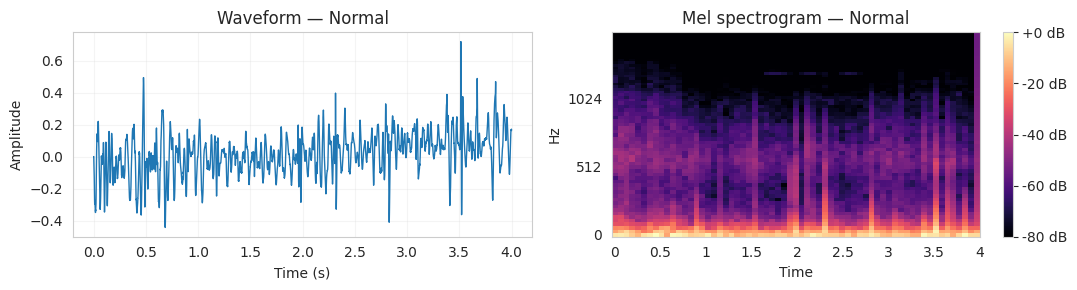

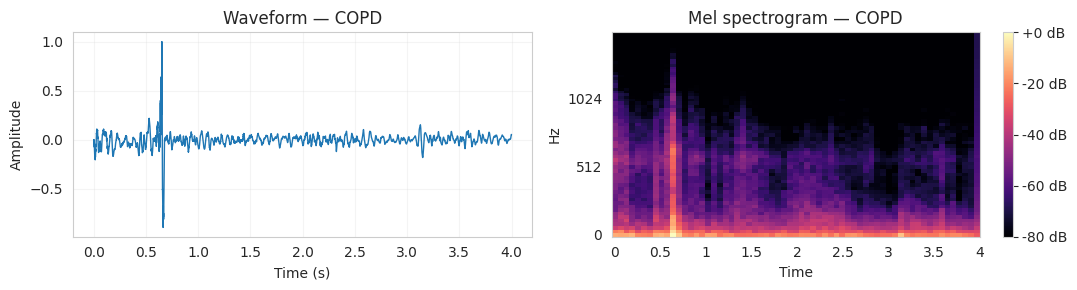

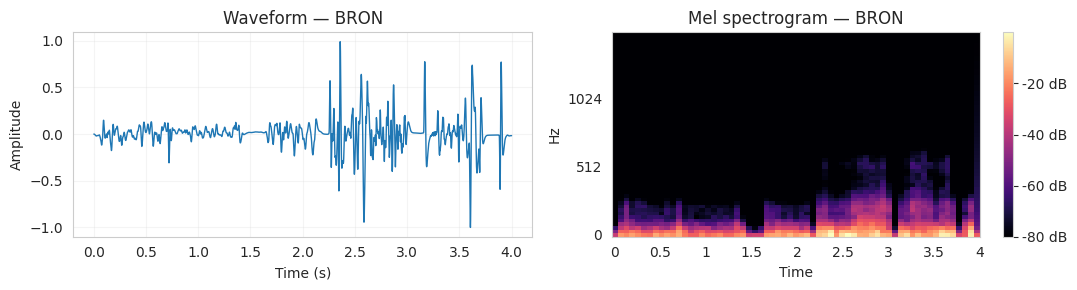

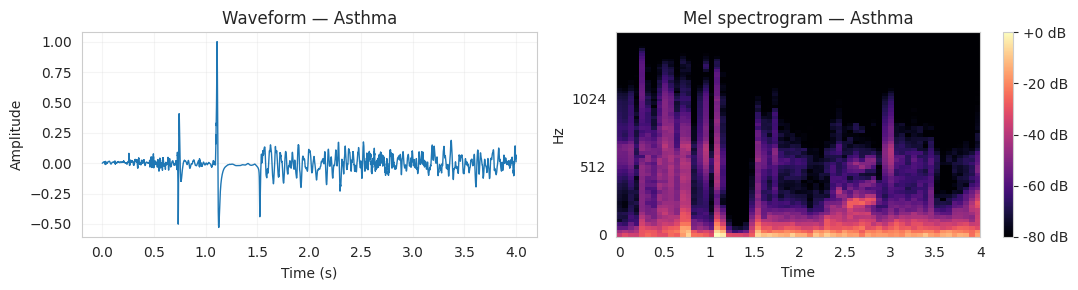

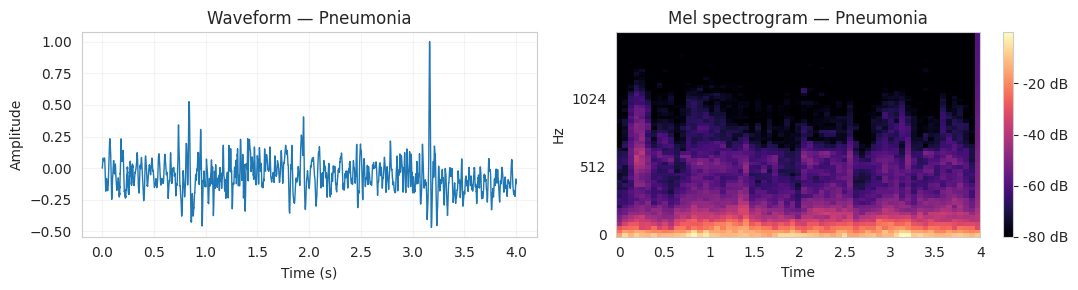

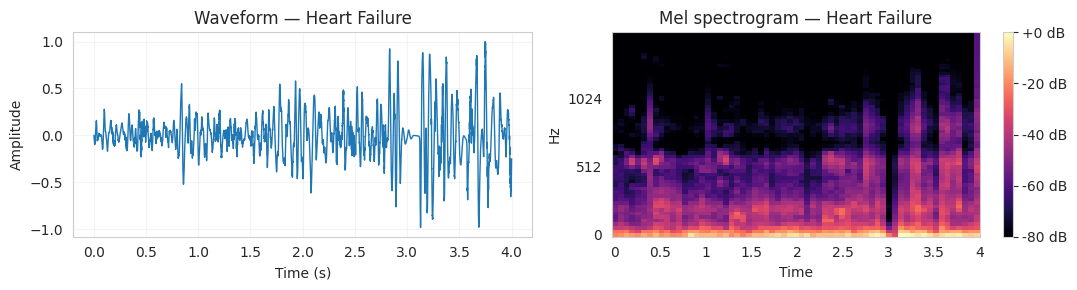

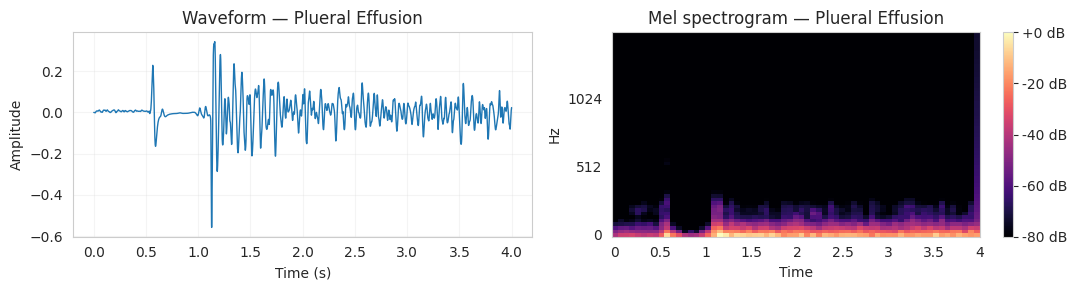

In [10]:
def view_sample(df_audio, label, index=0):
    # filtra por label y dibuja la muestra index
    sub = df_audio[df_audio["label"] == label]
    if sub.empty:
        print(f"No samples for label={label}"); return
    index = max(0, min(index, len(sub)-1))
    row = sub.iloc[index]
    y = fix_length_16000(row["data"])
    sr = int(row.get("sample_rate", SAMPLE_RATE))

    plt.figure(figsize=(11,3))
    # Waveform
    plt.subplot(1,2,1)
    t = np.arange(len(y))/sr
    plt.plot(t, y, linewidth=1)
    plt.title(f"Waveform — {label}")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.2)
    # Spectrogram
    plt.subplot(1,2,2)
    S_db = compute_mel_spectrogram(y, sr)
    librosa.display.specshow(S_db, sr=sr, hop_length=HOP, x_axis="time", y_axis="mel", fmax=sr/2)
    plt.title(f"Mel spectrogram — {label}")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout(); plt.show()

# ejemplo:
view_sample(df_audio, "Normal", index=0)
view_sample(df_audio, "COPD", index=0)
view_sample(df_audio, "BRON", index=0)
view_sample(df_audio, "Asthma", index=0)
view_sample(df_audio, "Pneumonia", index=0)
view_sample(df_audio, "Heart Failure", index=0)
view_sample(df_audio, "Plueral Effusion", index=0)

# Part 2(B) — Interactive Waveform & Spectrogram Browser (16k samples)

This block builds an **interactive viewer** to explore waveforms and time–frequency representations (Mel and CWT) per label, aligned to the requirement of using **samples of length = 16,000** (with trimming and padding when needed).

- **Preprocessing**
  - Trim leading silence/noise: skips the first `LEAD_TRIM_S` seconds per clip.
  - Z-score **amplitude normalization** for comparability across recordings.
  - Fix length to **16,000 samples** (pad/truncate).

- **Representations**
  - **Mel spectrogram**: `librosa.feature.melspectrogram` → dB scale (baseline view).
  - **Continuous Wavelet Transform (CWT)**:
    - **Morlet** and **Ricker** wavelets with frequency axis shown in **log-Hz**.

- **Interactive controls (ipywidgets)**
  - **Label** dropdown: choose a diagnosis label.
  - **Index** slider: iterate through recordings within the selected label.
  - **View** dropdown: switch between *Mel*, *Morlet (CWT)*, and *Ricker (CWT)*.

- **Plots**
  - **Waveform** (top-left): z-scored amplitude vs. time.
  - **Time–frequency map** (top-right): Mel / Morlet-CWT / Ricker-CWT with colorbar.
  - Layout uses `matplotlib` and `librosa.display` (for Mel).

**Assumptions**
- `df_audio` exists and contains at least: `data` (np.array), `label`, `filename`, `sample_rate`.
- Uses a single, consistent `SAMPLE_RATE` from `df_audio`.
- Dependencies: `matplotlib`, `librosa`, `scipy`, `ipywidgets` (ensure Jupyter widgets are enabled).

**Notes**
- Adjust `LEAD_TRIM_S`, `N_MELS`, `N_FFT`, `HOP`, and CWT scale ranges to match your dataset characteristics.
- The log-frequency edges for CWT are derived from scale center frequencies to avoid band overlap artifacts.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import ipywidgets as widgets
from ipywidgets import Dropdown, IntSlider
from IPython.display import display, clear_output
from scipy.signal import cwt, morlet2, ricker  # CWT

# ------------ parámetros / utils ------------
SAMPLE_RATE = int(df_audio["sample_rate"].iloc[0])  # p.ej. 4000
FIXED_LEN   = 16000
N_MELS      = 128
N_FFT       = 256
HOP         = 128
LEAD_TRIM_S = 0.6  # segundos a recortar al inicio de cada audio

In [12]:


def trim_leading_seconds(y: np.ndarray, sr: int, secs: float = LEAD_TRIM_S):
    """Recorta los primeros 'secs' segundos; si es más corto, devuelve array vacío."""
    off = int(round(secs * sr))
    if off <= 0:
        return y
    return y[off:] if off < len(y) else np.array([], dtype=y.dtype)

def zscore_normalize(y):  # normaliza amplitud para comparar señales
    return (y - np.mean(y)) / (np.std(y) + 1e-8)

def fix_length_16000(y, L=FIXED_LEN):
    return (np.pad(y, (0, L-len(y)), mode="constant") if len(y) < L else y[:L]).astype(np.float32, copy=False)

# --- Mel (baseline) ---
def compute_mel_spectrogram(y, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop=HOP):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop, fmax=sr//2)
    return librosa.power_to_db(S, ref=np.max)

# --- Wavelets (Morlet / Ricker) ---
def compute_cwt_morlet(y, sr=SAMPLE_RATE, w=6.0, n_scales=128, min_period_ms=12.5, max_period_ms=500.0):
    # periodos (ms) -> escalas (a, en muestras)
    min_scale = max(1, int(np.round((min_period_ms/1000.0) * sr * w / (2*np.pi))))
    max_scale = int(np.round((max_period_ms/1000.0) * sr * w / (2*np.pi)))
    widths = np.unique(np.linspace(min_scale, max_scale, n_scales).astype(int))
    coef = cwt(y, morlet2, widths, w=w)        # (n_scales, T)
    power = np.abs(coef)**2
    f_hz = (w * sr) / (2*np.pi*widths)         # Hz aproximados
    return power, f_hz

def compute_cwt_ricker(y, sr=SAMPLE_RATE, n_scales=128, min_period_ms=4.0, max_period_ms=200.0):
    min_scale = max(1, int(np.round((min_period_ms/1000.0) * sr / 2.0)))
    max_scale = int(np.round((max_period_ms/1000.0) * sr / 2.0))
    widths = np.unique(np.linspace(min_scale, max_scale, n_scales).astype(int))
    coef = cwt(y, ricker, widths)              # (n_scales, T)
    power = np.abs(coef)**2
    f_hz = sr / (2*np.pi*widths)               # Hz aprox
    return power, f_hz

# ---- helper: bordes log para pcolormesh en frecuencia ----
def _freq_edges_from_centers_log(f_centers_hz: np.ndarray) -> np.ndarray:
    """Genera bordes log a partir de centros (Hz). f_centers_hz > 0."""
    f = np.sort(np.asarray(f_centers_hz))          # ascendente
    # puntos medios geométricos entre centros
    mids = np.sqrt(f[:-1] * f[1:])
    edges = np.empty(f.size + 1, dtype=float)
    edges[1:-1] = mids
    ratio0 = f[1] / f[0]
    ration = f[-1] / f[-2]
    edges[0] = f[0] / np.sqrt(ratio0)              # extrapola abajo
    edges[-1] = f[-1] * np.sqrt(ration)            # extrapola arriba
    return edges

def _build_index(df_audio):
    d = {}
    for i, r in df_audio.iterrows():
        lab = str(r["label"])
        d.setdefault(lab, []).append(i)
    return {k: d[k] for k in sorted(d)}

# ------------ visor interactivo (log-Hz en wavelets) ------------
def show_browser(df_audio):
    idx_map = _build_index(df_audio)
    labels = list(idx_map.keys())

    dd_label = Dropdown(options=labels, value=labels[0], description="Label:")
    slider   = IntSlider(min=0, max=max(0, len(idx_map[dd_label.value])-1), step=1, value=0, description="Index:")
    dd_repr  = Dropdown(options=[("Mel", "mel"), ("Morlet (CWT)", "morlet"), ("Ricker (CWT)", "ricker")],
                        value="mel", description="View:")
    out = widgets.Output()

    def _redraw(*_):
        label = dd_label.value
        i_list = idx_map[label]
        idx = min(max(slider.value, 0), len(i_list)-1)
        slider.value = idx

        row = df_audio.loc[i_list[idx]]
        fname = str(row.get("filename", "unknown"))
        sr = int(row.get("sample_rate", SAMPLE_RATE))

        y  = fix_length_16000(zscore_normalize(trim_leading_seconds(row["data"],sr, secs=LEAD_TRIM_S))) # skip first 0.6seg then z-normalize and fix length 
        t  = np.arange(len(y)) / sr

        with out:
            clear_output(wait=True)
            plt.figure(figsize=(12, 6))

            # Waveform
            ax1 = plt.subplot(2, 2, 1)
            ax1.plot(t, y, linewidth=1)
            ax1.set_title(f"{fname} — Waveform (z-score) — {label}")
            ax1.set_xlabel("Time (s)"); ax1.set_ylabel("Amplitude (z)")
            ax1.grid(True, alpha=0.2)

            # Espectro / Wavelet (columna derecha arriba)
            ax2 = plt.subplot(2, 2, 2)

            if dd_repr.value == "mel":
                ax2.cla()

                S_db = compute_mel_spectrogram(y, sr)
                im = librosa.display.specshow(
                    S_db, sr=sr, hop_length=HOP,
                    x_axis="time", y_axis="mel", fmax=sr/2, ax=ax2
                )
                ax2.set_title(f"Mel spectrogram — {label}")
                plt.colorbar(im, ax=ax2, format="%+2.0f dB")

            elif dd_repr.value == "morlet":
                power, f_hz = compute_cwt_morlet(y, sr=sr, w=6.0, n_scales=64, min_period_ms=12.5, max_period_ms=500.0)
                # ordenar por frecuencia ascendente para malla log
                order = np.argsort(f_hz)
                f_ord = f_hz[order]
                P_ord = power[order, :]
                # bordes en tiempo y frecuencia
                t_edges = np.linspace(0, len(y)/sr, P_ord.shape[1] + 1)
                f_edges = _freq_edges_from_centers_log(f_ord)
                pm = ax2.pcolormesh(t_edges, f_edges, P_ord, shading="auto")
                ax2.set_yscale("log"); ax2.set_ylim(f_edges[0], f_edges[-1])
                ax2.set_title(f"CWT Morlet power — {label}")
                ax2.set_xlabel("Time (s)"); ax2.set_ylabel("Frequency (Hz)")
                plt.colorbar(pm, ax=ax2)

            else:  # ricker
                power, f_hz = compute_cwt_ricker(y, sr=sr, n_scales=64, min_period_ms=4.0, max_period_ms=200.0)
                order = np.argsort(f_hz)
                f_ord = f_hz[order]
                P_ord = power[order, :]
                t_edges = np.linspace(0, len(y)/sr, P_ord.shape[1] + 1)
                f_edges = _freq_edges_from_centers_log(f_ord)
                pm = ax2.pcolormesh(t_edges, f_edges, P_ord, shading="auto")
                ax2.set_yscale("log"); ax2.set_ylim(f_edges[0], f_edges[-1])
                ax2.set_title(f"CWT Ricker power — {label}")
                ax2.set_xlabel("Time (s)"); ax2.set_ylabel("Frequency (Hz)")
                plt.colorbar(pm, ax=ax2)

            # segunda fila: misma vista que arriba para comparar otro índice rápido (opcional)
            ax3 = plt.subplot(2, 2, 3)
            ax3.axis("off")
            ax4 = plt.subplot(2, 2, 4)
            ax4.axis("off")

            plt.tight_layout()
            plt.show()

    def _on_label_change(change):
        if change["name"] == "value":
            n = len(idx_map[change["new"]])
            slider.max = max(0, n-1)
            slider.value = 0
            _redraw()

    dd_label.observe(_on_label_change, names="value")
    slider.observe(_redraw, names="value")
    dd_repr.observe(_redraw, names="value")

    _redraw()
    display(widgets.HBox([dd_label, slider, dd_repr]), out)


In [13]:
show_browser(df_audio)
show_browser(df_audio)


Output()

Output()

**PART C** Extract Audio Features 

In [14]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert
from scipy.stats import skew, kurtosis


def pad_or_trim(y: np.ndarray, L: int = FIXED_LEN):
    if len(y) < L:
        y = np.pad(y, (0, L-len(y)), mode="constant")
    else:
        y = y[:L]
    return y.astype(np.float32, copy=False)

# ============================
# Helpers de features
# ============================
def amplitude_envelope(y: np.ndarray):
    """
    Envelope por transformada de Hilbert (magnitud de la señal analítica).
    """
    if y.size == 0:
        return np.zeros(1, dtype=np.float32)
    return np.abs(hilbert(y))

def crest_factor(y: np.ndarray):
    """
    Crest factor = peak / RMS.
    """
    if y.size == 0:
        return 0.0
    peak = np.max(np.abs(y))
    rms  = np.sqrt(np.mean(y**2) + 1e-12)
    return float(peak / (rms + 1e-12))

def peak_to_average(y: np.ndarray):
    """
    Peak-to-Average (peak / mean(|y|)).
    """
    if y.size == 0:
        return 0.0
    peak = np.max(np.abs(y))
    avg  = np.mean(np.abs(y)) + 1e-12
    return float(peak / avg)

def rms_energy(y: np.ndarray):
    """
    Devuelve (RMS, Energy=sum(y^2)).
    """
    if y.size == 0:
        return 0.0, 0.0
    e = float(np.sum(y**2))
    r = float(np.sqrt(np.mean(y**2) + 1e-12))
    return r, e

def zero_crossing_rate(y: np.ndarray):
    """
    ZCR global (proporción de cambios de signo).
    """
    if y.size < 2:
        return 0.0
    s = np.sign(y)
    s[s==0] = 1
    zc = np.sum(s[:-1] * s[1:] < 0)
    return float(zc / (y.size - 1))

def robust_stats(y: np.ndarray):
    """
    Estadísticas globales: mean, std, median, mad, skew, kurt, p10, p90.
    """
    if y.size == 0:
        return dict(mean=0, std=0, median=0, mad=0, skew=0, kurt=0, p10=0, p90=0)
    mean_ = float(np.mean(y))
    std_  = float(np.std(y))
    med   = float(np.median(y))
    mad   = float(np.median(np.abs(y - med)))
    sk    = float(skew(y, bias=False))
    ku    = float(kurtosis(y, fisher=True, bias=False))
    p10   = float(np.percentile(y, 10))
    p90   = float(np.percentile(y, 90))
    return dict(mean=mean_, std=std_, median=med, mad=mad, skew=sk, kurt=ku, p10=p10, p90=p90)

def autocorr_features(y: np.ndarray, sr: int):
    """
    Autocorrelación normalizada y extracción de:
    - max_acf (excluyendo lag 0),
    - lag_peak (primer pico fuerte por encima de un umbral),
    - f0_est (sr / lag_peak) si aplica.
    """
    if y.size < 4:
        return dict(max_acf=0.0, lag_peak=0, f0_est=0.0)

    # autocorrelación 'full', normalizada por var
    y0 = y - np.mean(y)
    denom = (np.sum(y0**2) + 1e-12)
    acf_full = np.correlate(y0, y0, mode='full') / denom
    acf = acf_full[acf_full.size//2:]  # lags >= 0

    # Ignora lag=0, busca picos desde un lag mínimo (evita micro-lags)
    min_lag = max(1, int(0.005 * sr))   # 5 ms
    max_lag = min(len(acf)-1, int(1.0 * sr))  # hasta 1 s

    if max_lag <= min_lag:
        return dict(max_acf=0.0, lag_peak=0, f0_est=0.0)

    seg = acf[min_lag:max_lag]
    max_acf = float(np.max(seg))
    lag_peak_rel = int(np.argmax(seg))  # índice dentro de 'seg'
    lag_peak = lag_peak_rel + min_lag

    f0 = float(sr / lag_peak) if lag_peak > 0 else 0.0
    return dict(max_acf=max_acf, lag_peak=int(lag_peak), f0_est=f0)

def hjorth_parameters(y: np.ndarray, sr: int) -> dict:
    """
    Hjorth: activity (var), mobility, complexity.
    mobility = sqrt(var(dy)/var(y))
    complexity = mobility(d2y)/mobility(dy)
    """
    if y.size < 3:
        return dict(hj_activity=0.0, hj_mobility=0.0, hj_complexity=0.0)

    y0 = y - np.mean(y)
    var0 = np.var(y0) + 1e-12

    dy = np.diff(y0)
    var1 = np.var(dy) + 1e-12

    d2y = np.diff(dy)
    var2 = np.var(d2y) + 1e-12

    mobility = np.sqrt(var1 / var0)
    mobility2 = np.sqrt(var2 / var1)
    complexity = mobility2 / (mobility + 1e-12)

    return dict(hj_activity=float(var0), hj_mobility=float(mobility), hj_complexity=float(complexity))

def envelope_vs_finestructure(y: np.ndarray):
    """
    Compara energía del sobre (Hilbert) vs señal:
    - env_rms, env_mean, env_p90
    - env_to_signal_rms_ratio = RMS(env) / RMS(y)
    - modulation_index = std(env)/mean(env)
    """
    if y.size == 0:
        return dict(env_rms=0.0, env_mean=0.0, env_p90=0.0,
                    env_to_signal_rms_ratio=0.0, env_mod_index=0.0)

    env = amplitude_envelope(y)
    env_rms = float(np.sqrt(np.mean(env**2) + 1e-12))
    env_mean = float(np.mean(env))
    env_p90 = float(np.percentile(env, 90))
    sig_rms = float(np.sqrt(np.mean(y**2) + 1e-12))
    ratio = float(env_rms / (sig_rms + 1e-12))
    mod_index = float(np.std(env) / (np.mean(env) + 1e-12))

    return dict(env_rms=env_rms, env_mean=env_mean, env_p90=env_p90,
                env_to_signal_rms_ratio=ratio, env_mod_index=mod_index)

# ============================
# Extractor principal
# ============================
def extract_classic_features(y_raw: np.ndarray, sr: int,
                             lead_trim_s: float = LEAD_TRIM_S,
                             fixed_len: int = FIXED_LEN):
    """
    Pipeline:
      1) recorta lead (secs)
      2) z-score
      3) fija longitud
      4) calcula features
    Retorna: dict con todas las características.
    """
    # 1) lead trim
    y = trim_leading_seconds(y_raw, sr, secs=lead_trim_s)
    # 2) z-score
    y = zscore_normalize(y) if y.size else y
    # 3) longitud fija
    y = pad_or_trim(y, L=fixed_len)

    feats = {}

    # Envelope y métricas relacionadas
    feats.update(envelope_vs_finestructure(y))

    # Potencia y picos
    rms_, energy_ = rms_energy(y)
    feats["rms"] = float(rms_)
    feats["energy"] = float(energy_)
    feats["crest_factor"] = crest_factor(y)
    feats["peak_to_avg"] = peak_to_average(y)

    # ZCR
    feats["zcr"] = zero_crossing_rate(y)

    # Estadísticas de amplitud
    feats.update({f"amp_{k}": v for k, v in robust_stats(y).items()})

    # Autocorrelación y f0
    feats.update(autocorr_features(y, sr))

    # Hjorth
    feats.update(hjorth_parameters(y, sr))

    return feats


##Extract Spectral Features##
# Part 2(C–D) — Spectral Feature Extraction (MFCC + STFT Stats)

This block extracts compact **spectral descriptors** per recording to feed classical ML models.

**What this cell does:**
- **MFCCs (D):**  
  - Compute **N_MFCC = 20** coefficients via `librosa.feature.mfcc` (`n_fft=512`, `hop=256`).  
  - Aggregate per-coefficient **mean** and **std** → features: `mfcc{1..20}_mean`, `mfcc{1..20}_std`.

- **STFT Log-Power Stats (C):**  
  - Compute magnitude-squared STFT → log-power (`librosa.power_to_db`).  
  - Global statistics over all time–freq bins:  
    - `spec_mean`, `spec_std`, **skewness**, **kurtosis**.

- **Outputs:**
  - Builds `df_feats_spectral` with one row per recording containing:  
    - Spectral features (MFCC means/stds + STFT stats).  
    - Metadata: `idx`, `filename`, `mode` (filter code), `label`, `patient_id`, `sample_rate`.

**Assumptions & notes**
- Expects `df_audio` with columns: `data` (np.array), `sample_rate`, `filename`, `filter_code`, `label`, `patient_id`.
- Amplitude scaling / fixed-length normalization should be applied **upstream** (e.g., z-score, 16k samples) for comparability.
- Statistical moments use `scipy.stats` (`skew`, `kurtosis`) over flattened spectrogram bins.


In [15]:
import numpy as np
import librosa
from scipy.stats import skew, kurtosis

EPS = 1e-10

def clean_vec(x):
    """Devuelve sólo valores finitos. Si queda vacío, regresa un 0."""
    x = np.asarray(x).ravel()
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.array([0.0], dtype=float)
    return x

def power_to_db_safe(S):
    """Evita -inf/NaN al convertir a dB."""
    S = np.asarray(S)
    S = np.maximum(S, EPS)          # clamp para evitar log(0)
    ref = S.max()
    if not np.isfinite(ref) or ref < EPS:
        ref = 1.0                   # referencia segura si el espectro es casi todo 0
    S_db = librosa.power_to_db(S, ref=ref, amin=EPS, top_db=None)
    # Asegurar finitos:
    S_db = np.nan_to_num(S_db, neginf=-120.0, posinf=0.0)
    return S_db

def robust_stats_1d_safe(x):
    """Stats robustas que nunca devuelven NaN."""
    x = clean_vec(x)
    mean_ = float(np.mean(x))
    std_  = float(np.std(x))
    med   = float(np.median(x))
    mad   = float(np.median(np.abs(x - med)))
    p10   = float(np.percentile(x, 10))
    p90   = float(np.percentile(x, 90))
    # skew/kurtosis devuelven NaN si la varianza es 0 o datos degenerados:
    if x.size < 3 or std_ < 1e-20:
        sk = 0.0
        ku = 0.0
    else:
        sk = float(skew(x, bias=False))
        ku = float(kurtosis(x, fisher=True, bias=False))
        if not np.isfinite(sk): sk = 0.0
        if not np.isfinite(ku): ku = 0.0
    return dict(mean=mean_, std=std_, median=med, mad=mad, p10=p10, p90=p90, skew=sk, kurt=ku)

def summarize_feature(vec, prefix):
    stats = robust_stats_1d_safe(vec)
    return {f"{prefix}_{k}": v for k, v in stats.items()}
def extract_librosa_superfeatures(y, sr, fixed_len=16000, n_mfcc=20, n_fft=512, hop=256, win_length=None):
    feats = {}

    # --- Prepro ---
    if y.ndim > 1:
        y = librosa.to_mono(y)
    if y.size == 0:
        y = np.zeros(fixed_len, dtype=np.float32)
    y = y - np.mean(y)
    rms = np.sqrt(np.mean(y**2) + EPS)
    y = y / rms
    y = pad_or_trim(y, L=fixed_len)

    # --- STFT ---
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=win_length))**2
    S_db = power_to_db_safe(S)
    feats.update(summarize_feature(S_db, "spec_db"))

    # --- Mel + flux ---
    S_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop, power=2.0)
    S_mel_db = power_to_db_safe(S_mel)
    flux = librosa.onset.onset_strength(S=S_mel_db, sr=sr, hop_length=hop)
    feats.update(summarize_feature(flux, "flux"))

    # --- Clásicos ---
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop)[0]
    feats.update(summarize_feature(zcr, "zcr"))

    rms_f = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop)[0]
    feats.update(summarize_feature(rms_f, "rms"))

    centroid  = librosa.feature.spectral_centroid(S=S, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=sr)[0]
    roll85    = librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85)[0]
    roll95    = librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.95)[0]
    flatness  = librosa.feature.spectral_flatness(S=S)[0]

    # Limpia antes de resumir
    feats.update(summarize_feature(clean_vec(centroid),  "centroid"))
    feats.update(summarize_feature(clean_vec(bandwidth), "bandwidth"))
    feats.update(summarize_feature(clean_vec(roll85),    "rolloff85"))
    feats.update(summarize_feature(clean_vec(roll95),    "rolloff95"))
    feats.update(summarize_feature(clean_vec(flatness),  "flatness"))

    # --- MFCCs + deltas ---
    mfcc  = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop)
    delta = librosa.feature.delta(mfcc, order=1)
    delta2= librosa.feature.delta(mfcc, order=2)
    for i in range(n_mfcc):
        feats.update(summarize_feature(clean_vec(mfcc[i]),   f"mfcc{i+1}"))
        feats.update(summarize_feature(clean_vec(delta[i]),  f"mfcc{i+1}_d1"))
        feats.update(summarize_feature(clean_vec(delta2[i]), f"mfcc{i+1}_d2"))

    # --- Chroma / Tonnetz (opcionales; si fallan, no NaNs) ---
    try:
        S_lin = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop))**2
        chroma = librosa.feature.chroma_stft(S=S_lin, sr=sr)
        for i in range(chroma.shape[0]):
            feats.update(summarize_feature(clean_vec(chroma[i]), f"chroma{i+1}"))
        feats.update(summarize_feature(clean_vec(chroma), "chroma_all"))
    except Exception:
        feats["chroma_all_mean"] = 0.0

    try:
        y_harm, _ = librosa.effects.hpss(y)
        tonnetz = librosa.feature.tonnetz(y=y_harm, sr=sr)
        for i in range(tonnetz.shape[0]):
            feats.update(summarize_feature(clean_vec(tonnetz[i]), f"tonnetz{i+1}"))
        feats.update(summarize_feature(clean_vec(tonnetz), "tonnetz_all"))
    except Exception:
        feats["tonnetz_all_mean"] = 0.0

    # --- Resumen Mel entero ---
    feats.update(summarize_feature(S_mel_db, "mel_db"))

    # --- Medidas globales ---
    peak = float(np.max(np.abs(y)))
    avg  = float(np.mean(np.abs(y))) + EPS
    cf   = float(peak / (np.sqrt(np.mean(y**2) + EPS)))
    feats.update(dict(
        peak=peak,
        mean_abs=avg,
        peak_to_avg=float(peak / avg),
        crest_factor=cf
    ))
    return feats


In [16]:
import numpy as np
import pandas as pd
from scipy.signal import cwt, morlet2, ricker
from scipy.stats import entropy, kurtosis


def zscore_normalize(y):
    return (y - np.mean(y)) / (np.std(y) + 1e-8)

def trim_leading_seconds(y, sr, secs=LEAD_TRIM_S):
    off = int(round(secs * sr))
    return y[off:] if off < len(y) else np.array([], dtype=y.dtype)

def pad_or_trim(y, L=FIXED_LEN):
    if len(y) < L: y = np.pad(y, (0, L-len(y)), mode="constant")
    else:          y = y[:L]
    return y.astype(np.float32, copy=False)

# ======== Wavelet transforms ========
def cwt_morlet_power(y, sr, w=6.0, n_scales=64, min_ms=12.5, max_ms=500.0):
    # escala ~ periodo*w/(2π)  -> elegimos escalas por rango de periodos
    a_min = max(1, int(np.round((min_ms/1000.0) * sr * w / (2*np.pi))))
    a_max = int(np.round((max_ms/1000.0) * sr * w / (2*np.pi)))
    widths = np.unique(np.linspace(a_min, a_max, n_scales).astype(int))
    coef = cwt(y, morlet2, widths, w=w)            # (n_scales, T)
    P = np.abs(coef)**2
    f_hz = (w * sr) / (2*np.pi*widths)             # Hz aprox por escala
    return P, f_hz

def cwt_ricker_power(y, sr, n_scales=64, min_ms=4.0, max_ms=200.0):
    a_min = max(1, int(np.round((min_ms/1000.0) * sr / 2.0)))
    a_max = int(np.round((max_ms/1000.0) * sr / 2.0))
    widths = np.unique(np.linspace(a_min, a_max, n_scales).astype(int))
    coef = cwt(y, ricker, widths)                  # (n_scales, T)
    P = np.abs(coef)**2
    f_hz = sr / (2*np.pi*widths)                   # Hz aprox
    return P, f_hz

# ======== Resúmenes (features) ========
# bandas típicas (Hz) para respiratorio; ajusta a tu SR si quieres
WAVE_BANDS_HZ = [(0,80), (80,200), (200,500), (500,1000)]

def summarize_cwt(P, f_hz, prefix="m"):
    """
    P: (n_scales, T) power ; f_hz: (n_scales,)
    Devuelve dict con centroid/spread/entropy + band energy ratios + tiempo.
    """
    feats = {}
    # ordenar por frecuencia ascendente
    order = np.argsort(f_hz)
    f = f_hz[order]
    S = P[order, :]  # (F,T)

    # espectro promedio (sobre tiempo) y energía temporal
    Ef = S.mean(axis=1)           # energía por frecuencia promedio
    Et = S.sum(axis=0)            # energía por tiempo

    tot = S.sum() + 1e-12
    feats[f"{prefix}_power_total"] = float(tot)

    # centroid/spread (en Hz) con espectro promedio Ef
    w = Ef / (Ef.sum() + 1e-12)
    f_cent = float((w * f).sum())
    f_spread = float(np.sqrt((w * (f - f_cent)**2).sum()))
    feats[f"{prefix}_f_centroid_hz"] = f_cent
    feats[f"{prefix}_f_spread_hz"]   = f_spread

    # entropy (normalizada) del espectro promedio
    p = w + 1e-12
    H = float(entropy(p, base=np.e) / np.log(len(p)))  # 0..1
    feats[f"{prefix}_f_entropy"] = H

    # band energy ratios
    for lo, hi in WAVE_BANDS_HZ:
        mask = (f >= lo) & (f < hi)
        band = float(S[mask, :].sum() / tot) if mask.any() else 0.0
        feats[f"{prefix}_band_{int(lo)}_{int(hi)}_pct"] = band

    # dinámica temporal (transientness)
    p50 = float(np.percentile(Et, 50))
    p95 = float(np.percentile(Et, 95))
    feats[f"{prefix}_time_contrast"] = float(p95 / (p50 + 1e-12))
    feats[f"{prefix}_time_kurtosis"] = float(kurtosis(Et, fisher=True, bias=False))

    # estadísticos globales del mapa
    feats[f"{prefix}_map_mean"] = float(S.mean())
    feats[f"{prefix}_map_std"]  = float(S.std())
    feats[f"{prefix}_map_skew"] = float(((S - S.mean())**3).mean() / (S.std()**3 + 1e-12))
    feats[f"{prefix}_map_kurt"] = float(kurtosis(S.flatten(), fisher=True, bias=False))

    return feats

def extract_wavelet_features_from_row(row,LEAD_TRIM_S = 0.6,FIXED_LEN = 16000):
    """
    row: una fila de df_audio con 'data', 'sample_rate', y metadatos.
    Devuelve dict con metadatos + features de Morlet y Ricker.
    """
    y_raw = row["data"]
    sr = int(row["sample_rate"])
    # prepro igual que en visualización
    y = pad_or_trim(zscore_normalize(trim_leading_seconds(y_raw, sr, LEAD_TRIM_S)), L=FIXED_LEN)

    # Morlet
    Pm, fm = cwt_morlet_power(y, sr, w=6.0, n_scales=128, min_ms=12.5, max_ms=500.0)
    feats_m = summarize_cwt(Pm, fm, prefix="morlet")

    # Ricker (transitorios)
    Pr, fr = cwt_ricker_power(y, sr, n_scales=128, min_ms=4.0, max_ms=200.0)
    feats_r = summarize_cwt(Pr, fr, prefix="ricker")

    # metadatos para merge
    return {
        "filename": str(row.get("filename","")),
        "patient_id": row.get("patient_id", None),
        "label": str(row.get("label","")),
        "mode": str(row.get("filter_code", row.get("mode",""))),
        **feats_m,
        **feats_r,
    }


##Fraiwan et al features##

In [17]:
# === Fraiwan et al. 2020 — Entropy features ===
# - Shannon entropy (tiempo): histograma con ancho de Scott; p = hist/sum(hist); ShaEn = -sum p log p
# - Log-energy entropy: LogEn = -sum (log p)^2   (sobre el mismo histograma de amplitud)
# - Spectral entropy (desde espectrograma de potencia): S(t,f) -> P(f) = sum_t S / sum_{f,t} S; SpeEn = -sum P log P
# - Dataset-wise min-max [0,1] por columna
#
# Por consistencia con el paper:
#   sr_target = 4000 Hz
#   dur_target_s = 5.0  →  n_target = 20000 muestras
#
# Entradas esperadas:
#   - df_audio con columnas: ["data", "sample_rate", "filename", "patient_id", "label", "mode" (o filter_code)]
#
# Salidas:
#   - df_feats_fraiwan con: ["filename","patient_id","label","mode","sha_entropy","log_energy_entropy","spec_entropy"]
#   - df_feats_clasic_spectral_entropy = merge con tus features ya existentes

import numpy as np
import pandas as pd
import librosa
from pathlib import Path

# ----------------------------
# Parámetros (paper-aligned)
# ----------------------------
SR_TARGET = 4000
DUR_S     = 5.0
N_TARGET  = int(SR_TARGET * DUR_S)

# Espectrograma: usa STFT de potencia; puedes ajustar n_fft/hop si lo requieres
N_FFT     = 512
HOP       = 128
WIN       = "hann"
FMIN      = 0
FMAX      = None  # a SR_TARGET/2

# ----------------------------
# Helpers
# ----------------------------
def _resample_pad_trim(y, sr, sr_target=SR_TARGET, n_target=N_TARGET):
    """Resample a sr_target y recorta/paddea a n_target."""
    if sr != sr_target:
        y = librosa.resample(y.astype(np.float32, copy=False), orig_sr=sr, target_sr=sr_target)
    if len(y) < n_target:
        y = np.pad(y, (0, n_target-len(y)), mode="constant")
    else:
        y = y[:n_target]
    return y.astype(np.float32, copy=False)

def _scott_bin_edges(x: np.ndarray):
    """Regla de Scott para ancho de bin; si var≈0, usa bins fijos."""
    x = np.asarray(x, dtype=np.float64)
    n  = x.size
    sd = np.std(x)
    if n < 2 or sd < 1e-12:
        # caso degenerado: 10 bins alrededor del valor medio
        m = float(np.mean(x)) if n > 0 else 0.0
        w = 1e-3 if sd < 1e-12 else 3.49*sd*(n**(-1/3))
        return np.linspace(m-5*w, m+5*w, 11)
    width = 3.49 * sd * (n ** (-1/3))
    nbins = int(np.ceil((x.max() - x.min()) / (width + 1e-12)))
    nbins = max(10, min(512, nbins))  # acotar
    return np.linspace(x.min(), x.max(), nbins+1)

def shannon_entropy_from_hist(p: np.ndarray):
    p = p[p > 0]
    return float(-(p * np.log(p)).sum())

import numpy as np
import librosa
from scipy.stats import entropy

# --- helpers nuevos ---
def _safe_entropy(p):
    p = p[p > 0]
    if p.size == 0:
        return 0.0
    H = float(-(p * np.log(p)).sum())
    # normaliza por log(k) para quedar en [0,1]
    return H / float(np.log(len(p)))

def _safe_log_energy_entropy(p):
    p = p[p > 0]
    if p.size == 0:
        return 0.0
    H = float(-np.sum((np.log(p))**2))
    # opcional: normaliza por (log(k))**2
    return H / float(np.log(len(p))**2 + 1e-12)

def _resample_pad_trim(y, sr, sr_target=SR_TARGET, n_target=N_TARGET):
    if sr != sr_target:
        y = librosa.resample(y.astype(np.float32, copy=False),
                             orig_sr=sr, target_sr=sr_target, res_type="kaiser_fast")
    if len(y) < n_target:
        y = np.pad(y, (0, n_target-len(y)), mode="constant")
    else:
        y = y[:n_target]
    return y.astype(np.float32, copy=False)

def spectral_entropy_from_S(S_power, sr=SR_TARGET, fmin=20, fmax=None):
    S_power = np.asarray(S_power, dtype=np.float64)
    if S_power.ndim != 2 or S_power.size == 0:
        return 0.0
    n_fft = (S_power.shape[0]-1)*2
    freqs = np.linspace(0, sr/2, S_power.shape[0])
    mask = (freqs >= (fmin or 0)) & (freqs <= (fmax or (sr/2)))
    if not np.any(mask):
        return 0.0
    Ef = S_power[mask, :].sum(axis=1)
    tot = Ef.sum()
    if tot <= 0:
        return 0.0
    p = Ef / tot
    p = p[p > 0]
    # entropía normalizada
    return float(-(p * np.log(p)).sum() / np.log(len(p)))

def compute_fraiwan_entropies(y: np.ndarray, sr: int):
    # 1) Resample + 5s @ 4kHz
    y = _resample_pad_trim(y, sr, SR_TARGET, N_TARGET)

    # 2) Opcional: normalizar amplitud para ShaEn/LogEn
    y_amp = y / (np.sqrt(np.mean(y**2) + 1e-12))

    # Histograma (Scott) sobre y_amp
    edges = _scott_bin_edges(y_amp)
    hist, _ = np.histogram(y_amp, bins=edges)
    p = hist.astype(np.float64)
    p = p / (p.sum() + 1e-12)

    # 3) Entropías de tiempo (normalizadas)
    sha  = _safe_entropy(p)
    loge = _safe_log_energy_entropy(p)

    # 4) Entropía espectral (normalizada) con máscara de frecuencias
    S = librosa.stft(y, n_fft=N_FFT, hop_length=HOP, window=WIN, center=True)
    S_power = np.abs(S)**2
    spec = spectral_entropy_from_S(S_power, sr=SR_TARGET, fmin=20, fmax=1000)

    return sha, loge, spec



## Fraiwan Features ##

## Feature caching & extractor wrappers ##

In [18]:
from __future__ import annotations
from pathlib import Path
import hashlib
import json
import numpy as np
import pandas as pd

# ============================
# Config
# ============================
CACHE_DIR = Path("./features_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

KEYS = ["filename","patient_id","label","mode"]  # claves de merge consistentes

# ============================
# Utils
# ============================
def _norm_keys(df: pd.DataFrame, keys=KEYS) -> pd.DataFrame:
    df = df.copy()
    for c in keys:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()
        else:
            # crea si falta, para evitar fallos de merge
            df[c] = "" if c != "patient_id" else None
    return df

def _hash_params(params: dict) -> str:
    s = json.dumps(params, sort_keys=True, default=str)
    return hashlib.md5(s.encode()).hexdigest()[:8]

def _save_parquet(df: pd.DataFrame, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_parquet(path, index=False)

def _load_parquet(path: Path) -> pd.DataFrame:
    return pd.read_parquet(path)

def _exists_ok(path: Path, force: bool) -> bool:
    return path.exists() and not force

def _sanitize(df: pd.DataFrame) -> pd.DataFrame:
    return (df.replace([np.inf, -np.inf], np.nan).fillna(0.0))

# ============================
# Extractores por fila (tú ya los tienes)
# ============================
# Debes tener implementados:
# - extract_classic_features(y, sr, lead_trim_s, fixed_len)
# - extract_librosa_superfeatures(y, sr, fixed_len, n_mfcc, n_fft, hop)
# - extract_wavelet_features_from_row(row)   # ya recibe fila y arma dict
# - compute_fraiwan_entropies(y, sr)         # devuelve (sha, loge, spec)

# ============================
# BUILDERS (df_audio -> df_features, con cache)
# ============================
def build_classic_df(df_audio: pd.DataFrame,
                     lead_trim_s: float = 0.6,
                     fixed_len: int = 16000,
                     cache_dir: Path = CACHE_DIR,
                     force: bool = False) -> pd.DataFrame:
    params = dict(kind="classic", lead_trim_s=lead_trim_s, fixed_len=fixed_len)
    h = _hash_params(params)
    path = cache_dir / f"classic_{h}.parquet"
    if _exists_ok(path, force):
        df = _load_parquet(path)
        return _sanitize(_norm_keys(df))
    # compute
    rows = []
    for i, r in df_audio.iterrows():
        y  = r["data"]; sr = int(r["sample_rate"])
        feats = extract_classic_features(y, sr, lead_trim_s=lead_trim_s, fixed_len=fixed_len)
        feats.update(dict(
            filename=str(r.get("filename","")),
            patient_id=r.get("patient_id", None),
            label=str(r.get("label","")),
            mode=str(r.get("filter_code", r.get("mode",""))),
            sample_rate=sr,
            idx=i,
        ))
        rows.append(feats)
    df = pd.DataFrame(rows)
    df = _sanitize(_norm_keys(df))
    _save_parquet(df, path)
    return df

def build_librosa_df(df_audio: pd.DataFrame,
                     fixed_len: int = 16000,
                     n_mfcc: int = 20,
                     n_fft: int = 512,
                     hop: int = 256,
                     cache_dir: Path = CACHE_DIR,
                     force: bool = False) -> pd.DataFrame:
    params = dict(kind="librosa", fixed_len=fixed_len, n_mfcc=n_mfcc, n_fft=n_fft, hop=hop)
    h = _hash_params(params)
    path = cache_dir / f"librosa_{h}.parquet"
    if _exists_ok(path, force):
        df = _load_parquet(path)
        return _sanitize(_norm_keys(df))
    rows = []
    for i, r in df_audio.iterrows():
        y  = r["data"]; sr = int(r["sample_rate"])
        f  = extract_librosa_superfeatures(y, sr, fixed_len=fixed_len, n_mfcc=n_mfcc, n_fft=n_fft, hop=hop)
        f.update(dict(
            idx=i,
            filename=str(r.get("filename","")),
            patient_id=r.get("patient_id", None),
            label=str(r.get("label","")),
            mode=str(r.get("filter_code", r.get("mode",""))),
            sample_rate=sr,
        ))
        rows.append(f)
    df = pd.DataFrame(rows)
    df = _sanitize(_norm_keys(df))
    _save_parquet(df, path)
    return df

def build_wavelet_df(df_audio: pd.DataFrame,
                     cache_dir: Path = CACHE_DIR,
                     force: bool = False,
                     prefix: str = "wavelet") -> pd.DataFrame:
    params = dict(kind="wavelet")
    h = _hash_params(params)
    path = cache_dir / f"{prefix}_{h}.parquet"
    if _exists_ok(path, force):
        df = _load_parquet(path)
        return _sanitize(_norm_keys(df))
    rows = []
    for _, r in df_audio.iterrows():
        try:
            rows.append(extract_wavelet_features_from_row(r))
        except Exception as e:
            print(f"[wavelet WARN] {r.get('filename','?')}: {e}")
    df = pd.DataFrame(rows)
    df = _sanitize(_norm_keys(df))
    _save_parquet(df, path)
    return df

def build_fraiwan_df(df_audio: pd.DataFrame,
                     cache_dir: Path = CACHE_DIR,
                     force: bool = False) -> pd.DataFrame:
    params = dict(kind="fraiwan")
    h = _hash_params(params)
    path = cache_dir / f"fraiwan_{h}.parquet"
    if _exists_ok(path, force):
        df = _load_parquet(path)
        return _sanitize(_norm_keys(df))
    rows = []
    for _, r in df_audio.iterrows():
        try:
            y = r["data"]; sr = int(r.get("sample_rate", 4000))
            sha, loge, spec = compute_fraiwan_entropies(y, sr)
            rows.append({
                "filename":   str(r.get("filename","")),
                "patient_id": r.get("patient_id", None),
                "label":      str(r.get("label","")),
                "mode":       str(r.get("filter_code", r.get("mode",""))),
                "sha_entropy": sha,
                "log_energy_entropy": loge,
                "spec_entropy": spec,
            })
        except Exception as e:
            print(f"[fraiwan WARN] {r.get('filename','?')}: {e}")
    df = pd.DataFrame(rows)
    df = _sanitize(_norm_keys(df))
    _save_parquet(df, path)
    return df

# ============================
# MERGE y ORQUESTADOR
# ============================
def merge_feature_dfs(dfs: list[pd.DataFrame], keys=KEYS) -> pd.DataFrame:
    assert len(dfs) >= 1
    base = _norm_keys(dfs[0])
    for d in dfs[1:]:
        base = base.merge(_norm_keys(d), on=keys, how="inner")
    return _sanitize(base)

def extract_all_features(df_audio: pd.DataFrame,
                         cache_dir: Path = CACHE_DIR,
                         force: bool = False) -> dict[str, pd.DataFrame]:
    # 1) construir cada set (si no existen)
    df_cla = build_classic_df(df_audio, cache_dir=cache_dir, force=force)
    df_lib = build_librosa_df(df_audio, cache_dir=cache_dir, force=force)
    df_wav = build_wavelet_df(df_audio, cache_dir=cache_dir, force=force)
    df_fra = build_fraiwan_df(df_audio, cache_dir=cache_dir, force=force)

    # 2) merges por claves consistentes
    df_cla_lib = merge_feature_dfs([df_cla, df_lib])
    df_full     = merge_feature_dfs([df_cla_lib, df_wav, df_fra])

    # 3) sanity final
    bad_cols = df_full.columns[df_full.isna().any()]
    if len(bad_cols):
        print("[WARN] NaNs detectados en columnas:", list(bad_cols))
        df_full = _sanitize(df_full)

    return dict(
        classic=df_cla,
        librosa=df_lib,
        wavelet=df_wav,
        fraiwan=df_fra,
        full=df_full
    )


In [19]:
outs = extract_all_features(df_audio, cache_dir=Path("./features_cache"), force=False)

df_feats_clasic   = outs["classic"]
df_feats_spectral = outs["librosa"]
df_feats_wavelet  = outs["wavelet"]
df_feats_fraiwan  = outs["fraiwan"]
df_feats_full     = outs["full"]

print("classic:", df_feats_clasic.shape)
print("librosa:", df_feats_spectral.shape)
print("wavelet:", df_feats_wavelet.shape)
print("fraiwan:", df_feats_fraiwan.shape)
print("FULL:", df_feats_full.shape)


/media/ricardo/bdecafd6-310a-43c1-ab12-59c0202656ee/SAMAY/Project/SAMAY/lib/python3.8/site-packages/librosa/core/pitch.py:103: UserWarning:

Trying to estimate tuning from empty frequency set.

/media/ricardo/bdecafd6-310a-43c1-ab12-59c0202656ee/SAMAY/Project/SAMAY/lib/python3.8/site-packages/librosa/core/pitch.py:103: UserWarning:

Trying to estimate tuning from empty frequency set.

/media/ricardo/bdecafd6-310a-43c1-ab12-59c0202656ee/SAMAY/Project/SAMAY/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1429: RuntimeWarning:

invalid value encountered in divide



classic: (336, 30)
librosa: (336, 675)
wavelet: (336, 32)
fraiwan: (336, 7)
FULL: (336, 732)


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Dict, Any, Tuple
from sklearn.preprocessing import StandardScaler

# UMAP import with fallback
try:
    import umap.umap_ as umap
except Exception:
    import umap  # in case your installation exposes UMAP here


def umap_per_patient(
    df_feats: pd.DataFrame,
    title: str = "UMAP per patient (concat EP|DP|BP with padding)",
    mode_order: List[str] = ["EP", "DP", "BP"],
    meta_cols: List[str] = ("filename", "label", "patient_id", "mode", "mode_clasic","idx","sample_rate"),
    keys_for_merge: List[str] = ("patient_id",),  # keys for merging with extra_merge
    extra_merge: Optional[pd.DataFrame] = None,   # optional DF to join at patient level
    # UMAP & scaling
    n_neighbors: int = 10,
    min_dist: float = 0.1,
    metric: str = "cosine",
    random_state: int = 42,
    do_plot: bool = True,
    figsize: Tuple[int, int] = (8, 6),
) -> Dict[str, Any]:
    """
    Builds one vector per patient by concatenating EP|DP|BP features (with padding)
    and projects with UMAP. Optionally joins an extra DF at the 'patient_id' level.

    Parameters:
    - df_feats: DataFrame with at least these meta columns:
                ['filename','label','patient_id','mode' or 'mode_clasic'].
                All other columns will be treated as features.
    - title: plot title.
    - mode_order: concatenation order of modes.
    - meta_cols: meta columns (not used as features).
    - keys_for_merge: keys to merge with extra_merge (default, 'patient_id').
    - extra_merge: optional DF to join to the final result by the provided keys.
    - n_neighbors, min_dist, metric, random_state: UMAP hyperparameters.
    - do_plot: if True, draws a scatter colored by the patient's majority label.
    - figsize: figure size.

    Returns:
    dict with:
      - df_pat: final per-patient DataFrame with 'umap_x','umap_y' (+ extra_merge if provided)
      - scaler: StandardScaler fitted on the concatenated columns
      - umap_model: fitted UMAP model
      - colnames_concat: list of concatenated feature column names
      - patient_label: DataFrame with the majority label per patient
    """
    df = df_feats.copy()

    # --- key coercion and cleaning ---
    for c in ["patient_id", "label"]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()
    # canonicalize 'mode'
    if "mode" not in df.columns or df["mode"].isna().all():
        if "mode_clasic" in df.columns:
            df["mode"] = df["mode_clasic"]
        else:
            raise ValueError("Couldn't find 'mode' or 'mode_clasic' column in df_feats.")
    df["mode"] = df["mode"].astype(str).str.strip()

    # --- define feature columns ---
    feat_cols = [c for c in df.columns if c not in meta_cols and c != "mode"]

    if len(feat_cols) == 0:
        raise ValueError("No feature columns remain after excluding meta_cols.")

    # --- aggregate by (patient_id, mode): mean if there are multiple records ---
    agg = (
        df.groupby(["patient_id", "mode"], as_index=False)[feat_cols]
          .mean()
    )

    # --- majority label per patient ---
    def _majority_label(g):
        return g["label"].mode().iloc[0] if len(g) else "Unknown"

    patient_label = (
        df.groupby("patient_id")
          .apply(_majority_label)
          .rename("patient_label")
          .reset_index()
    )

    # --- patient × (features_EP + features_DP + features_BP) matrix with padding ---
    rows = []
    pids = sorted(df["patient_id"].dropna().unique())

    for pid in pids:
        vecs = []
        for m in mode_order:
            row = agg[(agg["patient_id"] == pid) & (agg["mode"] == m)]
            if len(row) == 1:
                v = row[feat_cols].to_numpy(dtype=float).ravel()
            else:
                v = np.zeros(len(feat_cols), dtype=float)  # padding if mode is missing
            vecs.append(v)
        concat_vec = np.concatenate(vecs, axis=0)
        rows.append({"patient_id": pid, "features": concat_vec})

    df_pat = pd.DataFrame(rows)
    colnames_concat = [f"{f}__{m}" for m in mode_order for f in feat_cols]

    X_pat = np.vstack(df_pat["features"].to_numpy())
    df_pat_feat = pd.DataFrame(X_pat, columns=colnames_concat)
    df_pat = pd.concat([df_pat[["patient_id"]].reset_index(drop=True), df_pat_feat], axis=1)

    # add majority label
    df_pat = df_pat.merge(patient_label, on="patient_id", how="left")

    # --- column-wise normalization ---
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(df_pat[colnames_concat].to_numpy(dtype=float))
    
    # --- UMAP ---
    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=random_state
    )
    X_umap = umap_model.fit_transform(X_norm)
    df_pat["umap_x"] = X_umap[:, 0]
    df_pat["umap_y"] = X_umap[:, 1]

    # --- optional merge with extra_merge ---
    if extra_merge is not None:
        df_pat = df_pat.merge(extra_merge, on=list(keys_for_merge), how="left")

    # --- plot ---
    if do_plot:
        plt.figure(figsize=figsize)
        sns.scatterplot(
            data=df_pat,
            x="umap_x", y="umap_y",
            hue="patient_label",
            s=60, palette="tab10", edgecolor="k", linewidth=0.3
        )
        plt.title(title)
        plt.xlabel("umap_x"); plt.ylabel("umap_y")
        plt.grid(True, alpha=0.25)
        plt.tight_layout()
        plt.show()

    return {
        "df_pat": df_pat,
        "scaler": scaler,
        "umap_model": umap_model,
        "colnames_concat": colnames_concat,
        "patient_label": patient_label,
    }


ModuleNotFoundError: No module named 'umap'

In [ ]:


umap_per_patient(
    df_feats=df_feats_clasic,
    title="UMAP per patient - Classic Features",
    # extra_merge=df_alguna_tabla_por_paciente,  # opcional
)

umap_per_patient(
    df_feats=df_feats_spectral,
    title="UMAP per patient - Spectral",
    # extra_merge=df_alguna_tabla_por_paciente,  # opcional
)

umap_per_patient(
    df_feats=df_feats_wavelet,
    title="UMAP per patient - wavelets",
    # extra_merge=df_alguna_tabla_por_paciente,  # opcional
)

umap_per_patient(
    df_feats=df_feats_fraiwan,
    title="UMAP per patient - Frawin",
    # extra_merge=df_alguna_tabla_por_paciente,  # opcional
)

umap_per_patient(
    df_feats=df_feats_full,
    title="UMAP per patient - Classic+Spectral+wavelets+Farwin",
    # extra_merge=df_alguna_tabla_por_paciente,  # opcional
)



In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# Claves/metadata que quieres preservar en el DF final
META_COLS = ["filename","patient_id","label","mode","idx","sample_rate","n_samples","lead_trim_s","fixed_len"]

def reduce_features_unsupervised(df: pd.DataFrame,
                                 meta_cols=META_COLS,
                                 var_threshold: float = 1e-5,
                                 corr_threshold: float = 0.90,
                                 fillna_value: float = 0.0):
    """
    Aplica:
      1) VarianceThreshold (descarta casi constantes)
      2) Drop por alta correlación (Pearson |r| > corr_threshold)
    Devuelve:
      - df_reduced: DataFrame coherente = [meta_cols + features_filtradas]
      - report: dict con columnas eliminadas en cada etapa y las conservadas
    """
    df = df.copy()

    # 0) Asegura que metas existan (si no, crea vacías)
    for c in meta_cols:
        if c not in df.columns:
            df[c] = np.nan

    # 1) Seleccionar solo numéricas como candidatas a features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Evitar tocar metadatos numéricos (ej. sample_rate)
    feature_cols = [c for c in numeric_cols if c not in meta_cols]

    X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(fillna_value)

    # 2) VarianceThreshold
    vt = VarianceThreshold(threshold=var_threshold)
    X_vt = vt.fit_transform(X)
    vt_keep = [col for col, keep in zip(feature_cols, vt.get_support()) if keep]
    vt_drop = [c for c in feature_cols if c not in vt_keep]

    # 3) Drop por correlación (sobre las que pasaron VT)
    if len(vt_keep) > 1:
        X_corr = pd.DataFrame(X_vt, columns=vt_keep, index=df.index)
        corr = X_corr.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        corr_drop = [col for col in upper.columns if any(upper[col] > corr_threshold)]
        corr_keep = [c for c in vt_keep if c not in corr_drop]
    else:
        corr_drop = []
        corr_keep = vt_keep

    # 4) Reconstruir DF coherente: metas + features finales
    kept_cols = meta_cols + corr_keep
    # Mantén sólo columnas que existen realmente (por si alguna meta no estaba)
    kept_cols = [c for c in kept_cols if c in df.columns or c in corr_keep]

    df_reduced = pd.concat([df[meta_cols], X[corr_keep]], axis=1)

    # 5) Reporte
    report = dict(
        total_features=len(feature_cols),
        removed_by_variance=len(vt_drop),
        removed_by_correlation=len(corr_drop),
        kept=len(corr_keep),
        dropped_variance=vt_drop,
        dropped_correlation=corr_drop,
        kept_features=corr_keep
    )

    return df_reduced, report


In [ ]:
df_coherent, rep = reduce_features_unsupervised(
    df_feats_full,
    meta_cols=["filename","patient_id","label","mode","idx","sample_rate"],
    var_threshold=1e-5,
    corr_threshold=0.90
)

print(rep["total_features"], "features totales")
print(rep["removed_by_variance"], "eliminadas por varianza baja")
print(rep["removed_by_correlation"], "eliminadas por colinealidad")
print(rep["kept"], "features finales")
print("Primeras 10 kept:", rep["kept_features"][:10])

# (opcional) guardar
# df_coherent.to_parquet("features_filtered.parquet", index=False)


In [ ]:
umap_per_patient(
    df_feats=df_coherent,
    title="UMAP per patient - Classic+Spectral+wavelets+Farwin",
    # extra_merge=df_alguna_tabla_por_paciente,  # opcional
)


## Third Part ##

** 0. To Track Classification Experiments**

In [ ]:
# !pip install mlflow
import mlflow, os, json, glob
from pathlib import Path
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("samay-audio")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def _save_cm_png(cm, labels, title, fname):
    fig, ax = plt.subplots(figsize=(5,4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45, colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    fig.savefig(fname, dpi=160, bbox_inches="tight")
    plt.close(fig)

def mlflow_log_classif(y_true_str, y_pred_str, y_true_enc, y_pred_enc, labels_order, labels_names,
                       run_params: dict, model_tag: str, file_prefix: str):
    """
    y_true_str / y_pred_str: etiquetas originales (strings) para el classification_report
    y_true_enc / y_pred_enc: etiquetas codificadas (enteros) para confusion_matrix
    labels_order: np.arange(n_clases)
    labels_names: lista con nombres de clases (para ejes)
    run_params: dict de hiperparámetros/nota del run
    model_tag: 'KNN' | 'LSTM' | 'RF' | etc
    file_prefix: prefijo de archivos ('knn_exp1', 'rf_full', etc)
    """
    # 1) params
    for k, v in (run_params or {}).items():
        mlflow.log_param(k, v)

    # 2) métricas
    rep = classification_report(y_true_str, y_pred_str, zero_division=0, output_dict=True)
    acc = float(rep.get("accuracy", 0.0))
    macro_f1 = float(rep.get("macro avg", {}).get("f1-score", 0.0))
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("macro_f1", macro_f1)

    # 3) classification_report -> CSV
    df_rep = pd.DataFrame(rep).T.reset_index().rename(columns={"index":"class"})
    csv_path = f"{file_prefix}_class_report.csv"
    df_rep.to_csv(csv_path, index=False)
    mlflow.log_artifact(csv_path, artifact_path="tables")

    # 4) matriz de confusión -> PNG
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc, labels=labels_order)
    png_path = f"{file_prefix}_confusion.png"
    _save_cm_png(cm, labels_names, f"{model_tag} — Confusion Matrix", png_path)
    mlflow.log_artifact(png_path, artifact_path="figures")

    return {"accuracy": acc, "macro_f1": macro_f1, "cm": cm, "report_df": df_rep}


In [ ]:
import numpy as np
import pandas as pd

# --- columnas categóricas en df_wide ---
CAT_COLS_WIDE = ["sound_types", "plane_tok", "side_tok", "level_tok", "gender"]
NUMERIC_META  = ["age"]  # edad la trataremos como numérica
KEYS = ["filename", "patient_id", "mode"]

# Asegura tipos/espacios consistentes para merge
def _norm_cols(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()
    return df

dfc = _norm_cols(df_coherent, ["filename","patient_id","mode","label"])
dfw = _norm_cols(df_wide.copy(), ["filename","patient_id","filter_code"])

# Selecciona en wide sólo lo que necesitamos
wide_keep = ["filename","patient_id","filter_code","diagnoses","label","age","gender",
             "sound_types","plane_tok","side_tok","level_tok"]
for c in wide_keep:
    if c not in dfw.columns:
        dfw[c] = np.nan
dfw = dfw[wide_keep].rename(columns={"filter_code":"mode"})

# Merge por (filename, patient_id, mode) para adjuntar categóricas a df_coherent
dfm = pd.merge(
    dfc, 
    dfw, 
    on=["filename","patient_id","mode"],
    how="left",
    suffixes=("","_wide")
)

# Columna de label “final” (prioriza df_coherent.label; si no, usa label_wide o primera diagnosis)
if "label" not in dfm or dfm["label"].isna().all():
    if "label_wide" in dfm:
        dfm["label"] = dfm["label_wide"]
    else:
        # fallback muy simple: primera diagnosis si está como lista
        dfm["label"] = dfm["diagnoses"].apply(lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) else "Unknown")
        
dfm.drop(columns=["idx","sample_rate","label_wide"], inplace=True)


In [ ]:
import numpy as np
import pandas as pd

# --- Config/inputs ---
META = ["filename","patient_id","label","mode","idx","sample_rate","n_samples","lead_trim_s","fixed_len"]

# num_cols = todas las numéricas reales que no estén en META
num_cols = [c for c in dfm.columns if c not in META and pd.api.types.is_numeric_dtype(dfm[c])]

# CAT_COLS_WIDE viene de tu entorno (categóricas a colapsar por paciente)
# mode_order: define el orden de modos a concatenar; si no lo das, inferimos uno estable
mode_order = sorted(dfm["mode"].dropna().unique().tolist())

# --- 1) Agregado NUM por (patient_id, mode) ---
agg = (
    dfm[["patient_id", "mode"] + num_cols]
      .groupby(["patient_id","mode"], as_index=False)
      .mean(numeric_only=True)
)

# --- 2) Majority label por paciente ---
def _majority(s: pd.Series):
    s = s.dropna()
    if s.empty:
        return np.nan
    m = s.mode(dropna=True)
    return m.iloc[0] if not m.empty else np.nan

patient_label = (
    dfm.groupby("patient_id", as_index=False)["label"]
       .agg(label_majority=_majority)
)

# --- 3) Majority para categóricas por paciente (sin usar 'first non-null') ---
#     (si todas son NaN/'' -> NaN)
def _majority_strict(s: pd.Series):
    s = s.dropna()
    s = s[s.astype(str).str.strip() != ""]
    if s.empty:
        return np.nan
    m = s.mode()
    return m.iloc[0] if len(m) else np.nan

if len(CAT_COLS_WIDE) > 0:
    cat_majority = (
        dfm[["patient_id"] + CAT_COLS_WIDE]
        .groupby("patient_id", as_index=False)
        .agg({c: _majority_strict for c in CAT_COLS_WIDE})
    )
else:
    cat_majority = pd.DataFrame({"patient_id": dfm["patient_id"].dropna().unique()})

# --- 4) Edad media por paciente (si la edad varía entre registros) ---
age_by_patient = (
    dfm.groupby("patient_id", as_index=False)["age"]
       .mean(numeric_only=True)
       .rename(columns={"age": "age_mean"})
)

# --- 5) Construir matriz paciente × (features ⨉ mode) con padding ---
rows = []
pids = sorted(dfm["patient_id"].dropna().unique())

for pid in pids:
    vecs = []
    for m in mode_order:
        row = agg[(agg["patient_id"] == pid) & (agg["mode"] == m)]
        if len(row) == 1:
            v = row[num_cols].to_numpy(dtype=float).ravel()
        else:
            v = np.zeros(len(num_cols), dtype=float)  # padding si falta el modo
        vecs.append(v)
    concat_vec = np.concatenate(vecs, axis=0)
    rows.append({"patient_id": pid, "features": concat_vec})

df_pat = pd.DataFrame(rows)

# Nombres de columnas expandidos feature__MODE para explotar el vector en columnas
colnames_concat = [f"{f}__{m}" for m in mode_order for f in num_cols]
# Explota la columna 'features' a columnas wide
num_wide = (
    df_pat
    .join(pd.DataFrame(df_pat["features"].tolist(), columns=colnames_concat))
    .drop(columns=["features"])
)

# --- 6) Ensamblar todo en un solo DataFrame por paciente ---
by_patient = (
    num_wide
    .merge(patient_label, on="patient_id", how="left")
    .merge(age_by_patient, on="patient_id", how="left")
    .merge(cat_majority, on="patient_id", how="left")
)

# Opcional: orden de columnas (id, label, age, cat..., num...)
first_cols = ["patient_id", "label_majority", "age_mean"]
cat_cols_present = [c for c in CAT_COLS_WIDE if c in by_patient.columns]
other_cols = [c for c in by_patient.columns if c not in set(first_cols + cat_cols_present)]
by_patient = by_patient[first_cols + cat_cols_present + other_cols]


One-Hot

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder

# --- columnas categóricas ---
CAT_MULTI = ["sound_types"]                     # multi-etiqueta
CAT_SINGLE = ["plane_tok", "side_tok", "level_tok", "gender"]  # una etiqueta

# ===== 1) Preparar X_num (como ya lo tenías) =====
X_num_cols = [c for c in by_patient.columns if "__" in c]  # columnas pivot por modo
X_num = by_patient[X_num_cols].fillna(0.0).astype(float)

# ===== 2) Categórica MULTI: sound_types -> MultiLabelBinarizer =====
def to_list_safe(v):
    """Convierte a lista: NaN->[], string->[string], lista/tuple/ndarray->list(..)"""
    if isinstance(v, (list, tuple, np.ndarray)):
        return [str(x).strip() for x in v if pd.notna(x) and str(x).strip() != ""]
    if pd.isna(v):
        return []
    return [str(v).strip()]  # si vino como string 'Normal' etc.

st_series = by_patient["sound_types"].apply(to_list_safe)
mlb = MultiLabelBinarizer()
X_st = mlb.fit_transform(st_series)
st_names = [f"st__{c}" for c in mlb.classes_]  # nombres de columnas multi-hot

# ===== 3) Categóricas SINGLE: OHE seguro (imputar NaN a 'UNK') =====
X_single_raw = by_patient[CAT_SINGLE].astype(object).copy()
X_single_raw = X_single_raw.fillna("UNK")  # NaN -> 'UNK'

ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_single = ohe.fit_transform(X_single_raw)
single_names = ohe.get_feature_names_out(CAT_SINGLE)

# ===== 4) Concatenar categóricas =====
X_cat = np.hstack([X_st, X_single])
cat_names = list(st_names) + list(single_names)

# ===== 5) Etiquetas y grupos =====
y = by_patient["label_majority"].astype(str).values
groups = by_patient["patient_id"].astype(str).values


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import hstack

# Concatenamos para un set "completo" (num + cat) si quieres entrenar juntos
from numpy import hstack
X_full = hstack([X_num.values, X_cat])

X_train_full, X_test_full, y_train, y_test, \
Xtr_num, Xte_num, Xtr_cat, Xte_cat = train_test_split(
    X_full, y, X_num, X_cat, 
    test_size=0.20, random_state=42, stratify=y
)

print("Train:", X_train_full.shape, "Test:", X_test_full.shape)

print("Train:", X_train_full.shape, "Test:", X_test_full.shape)


MrMR

In [ ]:
# --- mRMR-like con scikit-learn: MI - alpha * redundancia (corr absoluta) ---
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# Parámetros
k = min(50, Xtr_num.shape[1])  # nº de features a seleccionar
alpha = 0.5                    # peso de penalización por redundancia (ajustable 0–1)

# 1) Relevancia: Mutual Information respecto a y
mi = mutual_info_classif(Xtr_num, y_train, random_state=42, discrete_features='auto')

# 2) Redundancia: matriz de correlación entre features (en train)
#    (usamos Pearson |corr| como proxy rápida de redundancia)
corr = np.corrcoef(Xtr_num, rowvar=False)  # shape (n_features, n_features)
corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
corr = np.clip(corr, -1.0, 1.0)
abs_corr = np.abs(corr)

n_features = Xtr_num.shape[1]
remaining = list(range(n_features))
selected = []

for t in range(min(k, n_features)):
    if not selected:
        # primera: la de mayor MI
        j = int(np.argmax(mi[remaining]))
        selected.append(remaining.pop(j))
    else:
        # para cada candidata, penalizamos por la mayor correlación con ya seleccionadas
        penalties = []
        for idx, feat in enumerate(remaining):
            max_red = abs_corr[feat, selected].max() if len(selected) else 0.0
            score = mi[feat] - alpha * max_red
            penalties.append(score)
        j = int(np.argmax(penalties))
        selected.append(remaining.pop(j))

sel_idx = np.array(selected, dtype=int)
print("mRMR-like (sklearn) top idx:", sel_idx[:10])

# 3) Aplica selección a train/test
# Asegura que sel_idx sean enteros válidos
sel_idx = np.asarray(sel_idx, dtype=int)

# 1) Nombres de las columnas seleccionadas (desde train)
if isinstance(Xtr_num, pd.DataFrame):
    # Comprobación de rango
    n_cols = Xtr_num.shape[1]
    if (sel_idx.min() < 0) or (sel_idx.max() >= n_cols):
        raise IndexError(f"indices fuera de rango: max={sel_idx.max()}, n_cols={n_cols}")

    selected_feat_names = Xtr_num.columns[sel_idx]
else:
    # Si Xtr_num es array, crea nombres sintéticos
    selected_feat_names = np.array([f"f{i}" for i in sel_idx])

print("Features seleccionadas (sample):", list(selected_feat_names[:10]))

# 2) Aplicar la misma selección por NOMBRE a train y test
if isinstance(Xtr_num, pd.DataFrame):
    Xtr_num_sel = Xtr_num.loc[:, selected_feat_names]
else:
    Xtr_num_sel = Xtr_num[:, sel_idx]

if isinstance(Xte_num, pd.DataFrame):
    # Usa los mismos nombres para garantizar alineación
    Xte_num_sel = Xte_num.loc[:, selected_feat_names]
else:
    Xte_num_sel = Xte_num[:, sel_idx]


In [ ]:
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler

# Escalado (UMAP suele ir mejor con features en escala comparable)
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr_num_sel)
Xte_scaled = scaler.transform(Xte_num_sel)

# UMAP no supervisado (2D para plot)
um = umap.UMAP(
    n_neighbors=15,    # estructura local; más alto => más global
    min_dist=0.1,      # compacidad de clusters (0.0 = más compacto)
    n_components=2,    # 2D para visualizar
    metric="euclidean",
    random_state=42
)
Ztr_2d = um.fit_transform(Xtr_scaled)
Zte_2d = um.transform(Xte_scaled)

# (Opcional) Plot rápido
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", rc={"figure.figsize": (6,5)})
sns.scatterplot(x=Ztr_2d[:,0], y=Ztr_2d[:,1],
                hue=y_train, palette="tab10", s=12, alpha=0.9, edgecolor=None)
plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2"); plt.title("UMAP 2D (train)")
plt.legend(title="Clase", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(); plt.show()


In [ ]:
# =========================
# Experimentos KNN (1 y 2)
# =========================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, accuracy_score
)

# ------------------------------------------------------------
# 0) Configuración común
# ------------------------------------------------------------
# Pipeline: escalado -> KNN
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

# Hiperparámetros del KNN
param_grid = {
    "clf__n_neighbors": list(range(3, 16)),      # 3..15
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]                             # 1=Manhattan, 2=Euclídea
}

# Diagnóstico rápido de y
print("dtype y:", getattr(y_train, "dtype", type(y_train)))
print("Ejemplo tipos:", {type(v) for v in np.asarray(y_train).flatten()})
print("Clases únicas (primeras 10):", np.unique(y_train)[:10])

# (opcional) Manejo de NaN en etiquetas
# y_train = pd.Series(y_train).fillna("__MISSING__")
# y_test  = pd.Series(y_test ).fillna("__MISSING__")

# Codificación de etiquetas (una sola vez)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# Validador CV: Leave-One-Out (como en el experimento 1 original)
loo = LeaveOneOut()

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, LeaveOneOut

def run_experiment(name, Xtr, Xte, ytr_enc, yte_enc, label_encoder, plot_cm=True):
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=LeaveOneOut(),
        scoring="f1_macro",
        n_jobs=-1,
        verbose=1
    )

    # === MLflow run ===
    with mlflow.start_run(run_name=f"KNN | {name}"):
        mlflow.log_param("cv", "LOO")
        mlflow.log_param("search_space_n_neighbors", "3..15")
        mlflow.log_param("weights", "uniform|distance")
        mlflow.log_param("p", "1|2")

        grid.fit(Xtr, ytr_enc)
        best_knn = grid.best_estimator_
        y_pred_enc = best_knn.predict(Xte)
        y_pred = label_encoder.inverse_transform(y_pred_enc)
        y_true = label_encoder.inverse_transform(yte_enc)

        # Log de mejores params (json)
        mlflow.log_param("best_params", json.dumps(grid.best_params_))
        print(f"\n[{name}] Mejores hiperparámetros:", grid.best_params_)
        print(f"[{name}] Mejor puntaje CV (f1_macro): {grid.best_score_:.4f}")

        # Métricas rápidas test
        f1_macro_test = f1_score(yte_enc, y_pred_enc, average="macro")
        acc_test = accuracy_score(yte_enc, y_pred_enc)

        # === Log a MLflow: report + CM (PNG) + métricas ===
        aux = mlflow_log_classif(
            y_true_str=y_true, y_pred_str=y_pred,
            y_true_enc=yte_enc, y_pred_enc=y_pred_enc,
            labels_order=np.arange(len(label_encoder.classes_)),
            labels_names=label_encoder.classes_,
            run_params={"model":"KNN", "experiment": name},
            model_tag="KNN",
            file_prefix=f"knn_{'exp1' if 'Full' in name else 'exp2'}"
        )

        results = {
            "best_params": grid.best_params_,
            "cv_f1_macro": float(grid.best_score_),
            "test_f1_macro": float(f1_macro_test),
            "test_accuracy": float(acc_test),
            "classification_report": aux["report_df"].to_string(index=False),
            "confusion_matrix": aux["cm"],
            "classes_": label_encoder.classes_,
            "best_estimator": best_knn
        }
        return results


# ------------------------------------------------------------
# 1) Experimento 1: Full features (X_train_full / X_test_full)
# ------------------------------------------------------------
exp1_results = run_experiment(
    name="Experimento 1 (Full features + LOO)",
    Xtr=X_train_full,
    Xte=X_test_full,
    ytr_enc=y_train_enc,
    yte_enc=y_test_enc,
    label_encoder=le,
    plot_cm=True
)

# ------------------------------------------------------------
# 2) Experimento 2: mRMR en numéricas + categóricas concatenadas
#     Debes tener previamente: Xtr_num_sel, Xtr_cat, Xte_num_sel, Xte_cat
# ------------------------------------------------------------
X_train_mrmr_cat = np.hstack([Xtr_num_sel, Xtr_cat])
X_test_mrmr_cat  = np.hstack([Xte_num_sel, Xte_cat])

exp2_results = run_experiment(
    name="Experimento 2 (mRMR num + cat + LOO)",
    Xtr=X_train_mrmr_cat,
    Xte=X_test_mrmr_cat,
    ytr_enc=y_train_enc,
    yte_enc=y_test_enc,
    label_encoder=le,
    plot_cm=True
)

# ------------------------------------------------------------
# 3) Key findings al final (resumen compacto)
# ------------------------------------------------------------
key_findings = {
    "exp1": {
        "setup": "Full features + LOO CV",
        "best_params": exp1_results["best_params"],
        "cv_f1_macro": exp1_results["cv_f1_macro"],
        "test_f1_macro": exp1_results["test_f1_macro"],
        "test_accuracy": exp1_results["test_accuracy"]
    },
    "exp2": {
        "setup": "mRMR(num) + cat + LOO CV",
        "best_params": exp2_results["best_params"],
        "cv_f1_macro": exp2_results["cv_f1_macro"],
        "test_f1_macro": exp2_results["test_f1_macro"],
        "test_accuracy": exp2_results["test_accuracy"]
    }
}

print("\n==================== KEY FINDINGS ====================")
for k, v in key_findings.items():
    print(f"\n{k} -> {v['setup']}")
    print(f"  best_params  : {v['best_params']}")
    print(f"  cv_f1_macro  : {v['cv_f1_macro']:.4f}")
    print(f"  test_f1_macro: {v['test_f1_macro']:.4f}")
    print(f"  test_accuracy: {v['test_accuracy']:.4f}")
print("=====================================================\n")

# (Opcional) Si quieres comparar rápidamente cuál ganó:
winner = max(
    [("exp1", key_findings["exp1"]["test_f1_macro"]),
     ("exp2", key_findings["exp2"]["test_f1_macro"])],
    key=lambda x: x[1]
)[0]
print(f"Mejor experimento por F1_macro en test: {winner}")


In [ ]:
# ============================================
# Deep Learning Experiments (LSTM / BiGRU / Transformer / TimesNet-like)
# mRMR(num) + cat, Stratified 10% validation, Callbacks, CM Heatmap
# ============================================
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --- Sklearn utils ---
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score
)

# --- TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, losses, metrics

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ============================================
# 0) Data prep (mRMR num + cat) + Label Encoding + Scaling
# ============================================
# Concatenación como en tu exp.2 de KNN
X_train_tab = np.hstack([Xtr_num_sel, Xtr_cat])   # (n_train, n_features)
X_test_tab  = np.hstack([Xte_num_sel, Xte_cat])   # (n_test,  n_features)

# Etiquetas -> enteros
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)
print(f"Clases: {list(le.classes_)}")

# (opcional) escalado de inputs tabulares
scaler = StandardScaler()
X_train_tab = scaler.fit_transform(X_train_tab)
X_test_tab  = scaler.transform(X_test_tab)

# ============================================
# 1) Stratified Train/Validation split (10%)
# ============================================
Xtr_tab, Xval_tab, ytr_enc, yval_enc = train_test_split(
    X_train_tab, y_train_enc, test_size=0.10, random_state=SEED, stratify=y_train_enc
)

# ============================================
# 2) Dar forma 3D para redes secuenciales
#    Si no tienes secuencia temporal, usamos seq_len=1
# ============================================
def to_3d(x2d):
    # (N, F) -> (N, T=1, F)
    return np.expand_dims(x2d, axis=1)

Xtr = to_3d(Xtr_tab)
Xval = to_3d(Xval_tab)
Xte  = to_3d(X_test_tab)

input_shape = Xtr.shape[1:]  # (T, F)

# ============================================
# 3) Model builders
# ============================================
def build_lstm(input_shape, num_classes, hidden=64, dropout=0.2):
    inp = layers.Input(shape=input_shape)
    x = layers.Masking()(inp)
    x = layers.LSTM(hidden, return_sequences=False)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="LSTM")

def build_bigru(input_shape, num_classes, hidden=64, dropout=0.2):
    inp = layers.Input(shape=input_shape)
    x = layers.Masking()(inp)
    x = layers.Bidirectional(layers.GRU(hidden, return_sequences=False))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="BiGRU")

def build_transformer(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, dropout=0.2):
    inp = layers.Input(shape=input_shape)              # (T, F)
    x = layers.Dense(d_model)(inp)                     # (T, d_model)

    # Positional encoding aprendible
    T = tf.shape(x)[1]
    pos = tf.range(start=0, limit=T, delta=1)
    pos_emb = layers.Embedding(input_dim=2048, output_dim=d_model)(pos)  # 2048 por si T varía
    pos_emb = pos_emb[tf.newaxis, ...]                # (1, T, d_model)
    x = x + pos_emb                                   # broadcast a (B, T, d_model)

    for _ in range(2):
        attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_out)

        # ⬇️ Cambio clave: usar models.Sequential, no layers.Sequential
        ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(d_model)
        ])
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn(x))

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="Transformer")

def build_timesnet_like(input_shape, num_classes, channels=64, dropout=0.2):
    """
    Bloque inspirado en TimesNet: multi-period 1D convs con diferentes kernels/dilataciones
    (no es la implementación oficial; sirve como baseline 'TimesNet-like')
    """
    inp = layers.Input(shape=input_shape)   # (T, F)

    # Proyección a canales
    x0 = layers.Dense(channels, activation="relu")(inp)  # (T, C)

    # Multi-period conv blocks
    ks = [1, 3, 5]            # kernels
    dil = [1, 2, 4]           # dilations
    feats = []
    for k in ks:
        for d in dil:
            y = layers.Conv1D(channels, kernel_size=k, dilation_rate=d, padding="causal", activation="relu")(x0)
            y = layers.BatchNormalization()(y)
            y = layers.Conv1D(channels, kernel_size=1, padding="same", activation="relu")(y)
            feats.append(layers.GlobalAveragePooling1D()(y))

    x = layers.Concatenate()(feats) if len(feats) > 1 else feats[0]
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="TimesNetLike")

MODEL_BUILDERS = {
    "LSTM": build_lstm,
    "BiGRU": build_bigru,
    "Transformer": build_transformer,
    "TimesNet": build_timesnet_like
}

# ============================================
# 4) Entrenamiento con callbacks y evaluación
# ============================================
def train_and_eval(model_name, Xtr, ytr, Xval, yval, Xte, yte, input_shape, num_classes, base_dir="nn_runs"):
    import os, numpy as np
    os.makedirs(base_dir, exist_ok=True)

    with mlflow.start_run(run_name=f"DL | {model_name}"):
        mlflow.log_param("model", model_name)
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("batch_size", 64)
        mlflow.log_param("epochs_max", 200)

        model = MODEL_BUILDERS[model_name](input_shape, num_classes)
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-3),
            loss=losses.SparseCategoricalCrossentropy(),
            metrics=[metrics.SparseCategoricalAccuracy(name="acc")]
        )

        # --- checkpoint para guardar el mejor peso ---
        ckpt_path = os.path.join(base_dir, f"best_{model_name}.weights.h5")
        cbs = [
            callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
            callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=1),
            callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss",
                                      save_best_only=True, save_weights_only=True, verbose=1)
        ]

        history = model.fit(
            Xtr, ytr,
            validation_data=(Xval, yval),
            epochs=200, batch_size=64,
            callbacks=cbs, verbose=1
        )

        # intentar cargar el mejor checkpoint por si EarlyStopping no coincide
        best_ckpt_exists = os.path.exists(ckpt_path)
        if best_ckpt_exists:
            try:
                model.load_weights(ckpt_path)
            except Exception as e:
                print(f"[WARN] No pude cargar {ckpt_path}: {e}")

        # log de validación
        mlflow.log_metric("val_loss_min", float(np.min(history.history["val_loss"])))
        if "val_acc" in history.history:
            mlflow.log_metric("val_acc_max", float(np.max(history.history["val_acc"])))
        elif "val_sparse_categorical_accuracy" in history.history:
            mlflow.log_metric("val_acc_max", float(np.max(history.history["val_sparse_categorical_accuracy"])))

        # evaluación test
        y_pred_proba = model.predict(Xte, verbose=0)
        y_pred_enc = np.argmax(y_pred_proba, axis=1)

        test_acc  = accuracy_score(yte, y_pred_enc)
        test_f1   = f1_score(yte, y_pred_enc, average="macro")
        print(f"\n[{model_name}] Test accuracy: {test_acc:.4f} | Test F1(macro): {test_f1:.4f}\n")

        # log MLflow: reporte + matriz de confusión
        y_true_str = le.inverse_transform(yte)
        y_pred_str = le.inverse_transform(y_pred_enc)
        aux = mlflow_log_classif(
            y_true_str=y_true_str, y_pred_str=y_pred_str,
            y_true_enc=yte, y_pred_enc=y_pred_enc,
            labels_order=np.arange(num_classes),
            labels_names=le.classes_,
            run_params={"model": model_name},
            model_tag=model_name,
            file_prefix=f"dl_{model_name.lower()}"
        )

        # (opcional) subir checkpoint como artefacto si existe (puede pesar)
        if best_ckpt_exists:
            try:
                mlflow.log_artifact(ckpt_path, artifact_path="checkpoints")
            except Exception as e:
                print(f"[INFO] No subí el checkpoint a MLflow: {e}")

        return {
            "model_name": model_name,
            "best_weights_path": ckpt_path if best_ckpt_exists else None,
            "val_loss_min": float(np.min(history.history["val_loss"])),
            "val_acc_max": float(np.max(history.history.get("val_acc",
                                     history.history.get("val_sparse_categorical_accuracy", [np.nan])))),
            "test_accuracy": float(test_acc),
            "test_f1_macro": float(test_f1),
            "classification_report": aux["report_df"].to_string(index=False),
            "confusion_matrix": aux["cm"]
        }



# ============================================
# 5) Correr los 4 modelos
# ============================================
key_findings = {}
for name in ["LSTM", "BiGRU", "Transformer", "TimesNet"]:
    print("\n" + "="*80)
    print(f"Entrenando: {name}")
    print("="*80)
    res = train_and_eval(
        model_name=name,
        Xtr=Xtr, ytr=ytr_enc,
        Xval=Xval, yval=yval_enc,
        Xte=Xte,  yte=y_test_enc,
        input_shape=input_shape,
        num_classes=num_classes,
        base_dir="nn_runs"
    )
    key_findings[name] = {
        "val_loss_min": res["val_loss_min"],
        "val_acc_max": res["val_acc_max"],
        "test_accuracy": res["test_accuracy"],
        "test_f1_macro": res["test_f1_macro"],
        "best_ckpt": res["best_weights_path"]
    }

# ============================================
# 6) Resumen final (Key Findings)
# ============================================
print("\n==================== KEY FINDINGS (DL) ====================")
for k, v in key_findings.items():
    print(f"\n{k}")
    print(f"  val_loss_min : {v['val_loss_min']:.4f}")
    print(f"  val_acc_max  : {v['val_acc_max'] if v['val_acc_max'] is not None else 'N/A'}")
    print(f"  test_f1_macro: {v['test_f1_macro']:.4f}")
    print(f"  test_accuracy: {v['test_accuracy']:.4f}")
    print(f"  best_ckpt    : {v['best_ckpt']}")
print("===========================================================\n")

# (Opcional) Modelo ganador por F1 en test
winner = max([(k, v["test_f1_macro"]) for k, v in key_findings.items()], key=lambda x: x[1])[0]
print(f"Mejor modelo (F1_macro test): {winner}")


In [ ]:
# =========================
# 3.c - RandomForest 
# =========================
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# ==========================================================
# 0) Etiquetas (reutiliza y_train/y_test existentes)
# ==========================================================
le_rf = LabelEncoder()
y_train_enc_rf = le_rf.fit_transform(y_train)
y_test_enc_rf  = le_rf.transform(y_test)

# CV estratificado (LOO en RF suele ser costoso y poco necesario)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================================
# 1) Definición del modelo y grid
#    - oob_score para evaluación interna (fuera de CV)
#    - class_weight para desbalance
# ==========================================================
rf = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    oob_score=True,         # requiere bootstrap=True
)

param_grid_rf = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 12, 18],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", 0.5],
    "clf__bootstrap": [True],                       # necesario para OOB
    "clf__class_weight": [None, "balanced_subsample"]
}

def run_rf_experiment(name, Xtr, Xte, ytr_enc, yte_enc, label_encoder,
                      plot_cm=True, do_perm_importance=True, feature_names=None):
    pipe = Pipeline([("clf", rf)])
    grid = GridSearchCV(
        estimator=pipe, param_grid=param_grid_rf,
        cv=cv, scoring="f1_macro", n_jobs=-1, verbose=1
    )

    with mlflow.start_run(run_name=f"RF | {name}"):
        mlflow.log_param("cv", "StratifiedKFold(5)")
        mlflow.log_param("oob_score", True)

        grid.fit(Xtr, ytr_enc)
        best_model = grid.best_estimator_
        rf_inner = best_model.named_steps["clf"]

        mlflow.log_param("best_params", json.dumps(grid.best_params_))
        print(f"\n[{name}] Mejores hiperparámetros:", grid.best_params_)
        print(f"[{name}] Mejor puntaje CV (f1_macro): {grid.best_score_:.4f}")

        # Pred test
        y_pred_enc = best_model.predict(Xte)
        y_pred = label_encoder.inverse_transform(y_pred_enc)
        y_true = label_encoder.inverse_transform(yte_enc)

        # === Log a MLflow: report + CM + métricas ===
        aux = mlflow_log_classif(
            y_true_str=y_true, y_pred_str=y_pred,
            y_true_enc=yte_enc, y_pred_enc=y_pred_enc,
            labels_order=np.arange(len(label_encoder.classes_)),
            labels_names=label_encoder.classes_,
            run_params={"model":"RandomForest", "experiment": name},
            model_tag="RF",
            file_prefix=f"rf_{'full' if 'Full' in name else 'mrmr'}"
        )

        # OOB
        oob = getattr(rf_inner, "oob_score_", None)
        if oob is not None:
            mlflow.log_metric("oob_score", float(oob))

        # (Opcional) Permutation Importance -> guarda PNG y súbelo
        if do_perm_importance:
            from sklearn.inspection import permutation_importance
            r = permutation_importance(best_model, Xte, yte_enc, n_repeats=10, random_state=42, n_jobs=-1, scoring="f1_macro")
            top_k = min(20, r.importances_mean.shape[0])
            idx = np.argsort(r.importances_mean)[::-1][:top_k]
            names = [f"feat_{i}" for i in idx] if feature_names is None else [feature_names[i] for i in idx]
            plt.figure(figsize=(8, 6))
            plt.barh(range(top_k), r.importances_mean[idx][::-1], xerr=r.importances_std[idx][::-1])
            plt.yticks(range(top_k), names[::-1])
            plt.xlabel("Permutation importance (Δf1_macro)")
            plt.title(f"{name} - Top-{top_k} features")
            plt.tight_layout()
            pi_path = f"rf_perm_importance_{'full' if 'Full' in name else 'mrmr'}.png"
            plt.savefig(pi_path, dpi=160, bbox_inches="tight"); plt.close()
            mlflow.log_artifact(pi_path, artifact_path="figures")

        return {
            "best_params": grid.best_params_,
            "cv_f1_macro": float(grid.best_score_),
            "test_f1_macro": float(aux['macro_f1']),
            "test_accuracy": float(aux['accuracy']),
            "classification_report": aux["report_df"].to_string(index=False),
            "confusion_matrix": aux["cm"],
            "classes_": label_encoder.classes_,
            "best_estimator": best_model,
            "oob_score": float(oob) if oob is not None else None
        }


# ==========================================================
# 2) Conjuntos de features (paralelo a tus Exp 1 y 2)
# ==========================================================
feature_sets = [
    ("RF - Full features", X_train_full, X_test_full),
    ("RF - mRMR(num) + cat", np.hstack([Xtr_num_sel, Xtr_cat]),
                             np.hstack([Xte_num_sel, Xte_cat])),
]

feature_names_full = None      # lista de strings o None
feature_names_mrmr = None      # idem

# ==========================================================
# 3) Ejecutar y recolectar resultados
# ==========================================================
rf_key_findings = {}
for fs_name, Xtr, Xte in feature_sets:
    feats_names = feature_names_full if "Full" in fs_name else feature_names_mrmr
    res = run_rf_experiment(
        name=fs_name,
        Xtr=Xtr, Xte=Xte,
        ytr_enc=y_train_enc_rf, yte_enc=y_test_enc_rf,
        label_encoder=le_rf,
        plot_cm=True,
        do_perm_importance=True,
        feature_names=feats_names
    )
    rf_key_findings[fs_name] = {
        "setup": f"{fs_name} + RandomForest + 5-fold CV + OOB",
        "best_params": res["best_params"],
        "cv_f1_macro": res["cv_f1_macro"],
        "test_f1_macro": res["test_f1_macro"],
        "test_accuracy": res["test_accuracy"],
        "oob_score": res["oob_score"]
    }

# ==========================================================
# 4) Resumen final: KEY FINDINGS RF
# ==========================================================
print("\n==================== KEY FINDINGS (RandomForest) ====================")
for k, v in rf_key_findings.items():
    print(f"\n{k} -> {v['setup']}")
    print(f"  best_params  : {v['best_params']}")
    print(f"  cv_f1_macro  : {v['cv_f1_macro']:.4f}")
    print(f"  test_f1_macro: {v['test_f1_macro']:.4f}")
    print(f"  test_accuracy: {v['test_accuracy']:.4f}")
    if v["oob_score"] is not None:
        print(f"  oob_score    : {v['oob_score']:.4f}")
print("=====================================================================\n")

# (Opcional) Ganador por F1_macro en test
winner = max(
    [(k, v["test_f1_macro"]) for k, v in rf_key_findings.items()],
    key=lambda x: x[1]
)[0]
print(f"Mejor configuración RF por F1_macro en test: {winner}")


##Key Findings ##

In [ ]:
import mlflow, pandas as pd, os, glob
from IPython.display import display, Markdown, Image
from mlflow import artifacts as mlart

exp_name = "samay-audio"
runs = mlflow.search_runs(experiment_names=[exp_name])

display(Markdown("# Key Findings"))

# 5.1 Tabla resumen (ordenada por macro_f1)
cols = ["run_id","run_name","params.model","params.best_params","metrics.accuracy","metrics.macro_f1","metrics.oob_score","start_time"]
present = [c for c in cols if c in runs.columns]
df_summary = runs[present].copy()
if "metrics.macro_f1" in df_summary:
    df_summary = df_summary.sort_values("metrics.macro_f1", ascending=False)
display(Markdown("## Resumen de runs"))
display(df_summary)

# 5.2 Mejor por modelo (si existe params.model)
if "params.model" in runs.columns:
    display(Markdown("## Mejores resultados por modelo"))
    best_by_model = (runs
        .dropna(subset=["metrics.macro_f1", "params.model"])
        .sort_values("metrics.macro_f1", ascending=False)
        .groupby("params.model")
        .head(1)
    )
    display(best_by_model[["params.model","run_name","metrics.accuracy","metrics.macro_f1","run_id"]])

# 5.3 Galería: **Matrices de confusión** por run
display(Markdown("## Matrices de confusión"))
for _, row in runs.iterrows():
    run_id = row["run_id"]
    run_name = row.get("run_name", run_id)
    # intenta descargar carpeta figures del run
    try:
        out_dir = mlart.download_artifacts(artifact_uri=f"runs:/{run_id}/figures")
    except Exception:
        continue
    pngs = sorted(glob.glob(os.path.join(out_dir, "*confusion*.png")))
    if not pngs:
        continue
    display(Markdown(f"**{run_name}**"))
    for p in pngs:
        display(Image(filename=p, width=580))


In [ ]:
# ===== Key Findings robusto (con matrices de confusión) =====
import mlflow, os, glob
import pandas as pd
from IPython.display import display, Markdown, Image
from mlflow import artifacts as mlart

EXP_NAME = "samay-audio"   # el mismo que usaste en set_experiment
runs = mlflow.search_runs(experiment_names=[EXP_NAME])

display(Markdown("# Key Findings"))

# -------- 1) Resumen de runs (columna correcta de nombre) --------
# Normaliza columnas disponibles
name_col = "tags.mlflow.runName" if "tags.mlflow.runName" in runs.columns else None
model_col = "params.model" if "params.model" in runs.columns else None

cols_wanted = ["run_id",
               name_col if name_col else None,
               model_col if model_col else None,
               "params.best_params" if "params.best_params" in runs.columns else None,
               "metrics.accuracy" if "metrics.accuracy" in runs.columns else None,
               "metrics.macro_f1" if "metrics.macro_f1" in runs.columns else None,
               "metrics.oob_score" if "metrics.oob_score" in runs.columns else None,
               "start_time" if "start_time" in runs.columns else None]
cols_wanted = [c for c in cols_wanted if c is not None and c in runs.columns]

df_sum = runs[cols_wanted].copy()
if "metrics.macro_f1" in df_sum.columns:
    df_sum = df_sum.sort_values("metrics.macro_f1", ascending=False)

# Renombra columnas para que se vean bonito
renames = {}
if name_col: renames[name_col] = "run_name"
if model_col: renames[model_col] = "model"
df_sum = df_sum.rename(columns=renames)

display(Markdown("## Resumen de runs"))
display(df_sum)

# -------- 2) Mejor por modelo (si existe params.model) --------
if model_col and "metrics.macro_f1" in runs.columns:
    display(Markdown("## Mejores resultados por modelo"))
    best_by_model = (runs
        .dropna(subset=["metrics.macro_f1", model_col])
        .sort_values("metrics.macro_f1", ascending=False)
        .groupby(model_col)
        .head(1)
    )
    bbm_show = best_by_model[["run_id",
                              name_col] if name_col else ["run_id"]].copy()
    if name_col: bbm_show = bbm_show.rename(columns={name_col: "run_name"})
    # añade métricas básicas si existen
    for c in ["metrics.accuracy", "metrics.macro_f1"]:
        if c in best_by_model.columns:
            bbm_show[c] = best_by_model[c].values
    display(bbm_show)

# -------- 3) Galería: matrices de confusión (y demás PNGs) --------
display(Markdown("## Matrices de confusión y figuras"))
any_fig = False

for _, row in runs.iterrows():
    run_id = row["run_id"]
    run_name = row.get(name_col, None) if name_col else None
    if not run_name:
        # Fallback: usa el run_id corto como nombre
        run_name = f"run_{run_id[:8]}"

    # Intenta descargar la carpeta "figures" del run
    try:
        out_dir = mlart.download_artifacts(artifact_uri=f"runs:/{run_id}/figures")
    except Exception:
        # si el run no tiene carpeta 'figures', saltamos
        continue

    # Preferimos archivos que contengan "confusion" en el nombre;
    # si no hay, mostramos todo lo que haya en PNG
    png_conf = sorted(glob.glob(os.path.join(out_dir, "*confusion*.png")))
    png_all  = sorted(glob.glob(os.path.join(out_dir, "*.png")))

    to_show = png_conf if png_conf else png_all
    if not to_show:
        continue

    any_fig = True
    display(Markdown(f"**{run_name}**  \n_run_id:_ `{run_id}`"))
    for p in to_show:
        display(Image(filename=p, width=580))

if not any_fig:
    display(Markdown("> No se encontraron PNGs en `figures/` de los runs. "
                     "Verifica que se estén logueando como `mlflow.log_artifact(<png>, artifact_path='figures')`."))
